In [1]:
# 시각화를 위한 나눔 글꼴 설치
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm -rf ~/.cache/matplotlib

# 한국어 자연어처리 패키지 설치
!pip install konlpy

# 라이브러리 호출
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os
import pandas as pd
import numpy as np
import re
from google.colab import drive
import json
import requests # API를 호출할 경우
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from konlpy.tag import Okt # 토큰화 작업을 위해 한국어 형태소 분석기 호출
from collections import Counter # 단어 빈도 계산을 위해 호출
import joblib # 모델 저장 및 로드를 위해 호출

# 폰트 설정
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

print("맷플롯립 폰트 환경설정 업데이트 완료.")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (12.9 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126380 files and direc

In [2]:
# 나눔고딕 글꼴 파일 경로
nanum_font_path_guesses = [
    '/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf',
]

found_font_file = None
for font_path in nanum_font_path_guesses:
    if os.path.exists(font_path):
        print(f"나눔고딕 글꼴 파일을 찾았습니다: {font_path}")
        found_font_file = font_path
        break

if found_font_file:
    try:
        # 찾은 글꼴 파일로 Matplotlib에 글꼴 추가
        fm.fontManager.addfont(found_font_file)
        print(f"Matplotlib에 {found_font_file} 글꼴을 추가했습니다.")

        # 추가된 글꼴 패밀리 이름 확인
        font_family_name = fm.FontProperties(fname=found_font_file).get_name()
        print(f"추가된 글꼴의 패밀리 이름: {font_family_name}")

        # Matplotlib의 기본 글꼴 설정을 추가된 글꼴로 변경
        plt.rc('font', family=font_family_name)
        plt.rcParams['axes.unicode_minus'] = False
        print(f"Matplotlib의 기본 글꼴 설정을 '{font_family_name}'으로 변경했습니다.")

    except Exception as e:
        print(f"글꼴 설정 중 오류 발생: {e}")

else:
    print("나눔고딕 글꼴 파일을 시스템에서 찾을 수 없습니다.")

나눔고딕 글꼴 파일을 찾았습니다: /usr/share/fonts/truetype/nanum/NanumGothic.ttf
Matplotlib에 /usr/share/fonts/truetype/nanum/NanumGothic.ttf 글꼴을 추가했습니다.
추가된 글꼴의 패밀리 이름: NanumGothic
Matplotlib의 기본 글꼴 설정을 'NanumGothic'으로 변경했습니다.


In [3]:
# Google Drive 마운트
drive.mount('/content/drive')

# Google Drive 경로 설정
drive_path = '/content/drive/MyDrive/Colab Notebooks/데이터'

# 로드할 파일 목록
target_files = [
    '서울도서관 장서 대출목록 (2018년 06월).csv',
    '서울도서관 장서 대출목록 (2019년 06월).csv',
    '서울도서관 장서 대출목록 (2020년 06월).csv',
    '서울도서관 장서 대출목록 (2021년 06월).csv',
    '서울도서관 장서 대출목록 (2022년 06월).csv',
    '서울도서관 장서 대출목록 (2023년 06월).csv',
    '서울도서관 장서 대출목록 (2024년 06월).csv',
    '서울도서관 장서 대출목록 (2025년 06월).csv',
    '울산도서관 장서 대출목록 (2020년 06월).csv',
    '울산도서관 장서 대출목록 (2021년 06월).csv',
    '울산도서관 장서 대출목록 (2022년 06월).csv',
    '울산도서관 장서 대출목록 (2023년 06월).csv',
    '울산도서관 장서 대출목록 (2024년 06월).csv',
    '울산도서관 장서 대출목록 (2025년 06월).csv',
    '한밭도서관 장서 대출목록 (2018년 06월).csv',
    '한밭도서관 장서 대출목록 (2019년 06월).csv',
    '한밭도서관 장서 대출목록 (2020년 06월).csv',
    '한밭도서관 장서 대출목록 (2021년 06월).csv',
    '한밭도서관 장서 대출목록 (2022년 06월).csv',
    '한밭도서관 장서 대출목록 (2023년 06월).csv',
    '한밭도서관 장서 대출목록 (2024년 06월).csv',
    '한밭도서관 장서 대출목록 (2025년 06월).csv'
]

# 로드된 데이터프레임을 담을 리스트
loaded_dfs = []

# target_files 리스트를 순회
for file_name in target_files:
    file_path = os.path.join(drive_path, file_name)
    print(f"  '{file_name}' 로드 시도 중...")

    # CSV 파일만 로드
    if file_path.lower().endswith('.csv'):
        df = None
        columns_to_load = ['도서명', '주제분류번호', '도서권수', '대출건수', '발행년도', '등록일자']

        # 인코딩 시도
        df = pd.read_csv(file_path, encoding='cp949', usecols=columns_to_load)

        # 파일 이름에서 도서관 이름, 연도, 월 추출
        base_name = os.path.splitext(file_name)[0]  # 확장자 제거

        extracted_library_name = "알수없음"
        extracted_year = -1
        extracted_month = -1

        # 정규표현식 패턴
        match = re.match(r'(.+?) 장서 대출목록 \((\d{4})년 (\d{2})월\)', base_name)

        if match:
            extracted_library_name = match.group(1).strip()  # 앞뒤 공백 제거
            extracted_year = int(match.group(2))
            extracted_month = int(match.group(3))
        else:
             print(f"  파일 이름 '{file_name}'이 일치하지 않습니다. 도서관명/연도/월 추출 실패.")
             extracted_library_name = base_name

        # 로드 성공 후 파일 이름에서 추출한 컬럼 추가
        df['도서관명'] = extracted_library_name
        df['연도_파일'] = extracted_year
        df['월_파일'] = extracted_month
        loaded_dfs.append(df)

    else:
        print(f"  '{file_name}'은(는) 파일명을 확인하세요.")


# 로드된 모든 데이터프레임 결합
if loaded_dfs:
    library_loan_df = pd.concat(loaded_dfs, ignore_index=True)
    print("\결합 완료")
    # 결합된 데이터프레임 컬명 확인
    display(library_loan_df.columns)
    # 결홥된 데이터프레임 고유값 확인
    display(library_loan_df['도서관명'].unique())
    display(library_loan_df['연도_파일'].unique())
    display(library_loan_df['월_파일'].unique())

else:
    print("\파일 로드 실패로 인해 데이터가 없습니다.")
    library_loan_df = pd.DataFrame()


## 초기 데이터 전처리
# 추천 시스템 구축에 필요한 핵심 컬럼 위주로 전처리
# '도서관명' 컬럼은 지역 필터링에 사용되므로 유지
# '대출건수' 컬럼은 인기도 계산에 사용되므로 유지
# '도서명' 컬럼은 TF-IDF에 사용되므로 유지
# '주제분류번호' 컬럼은 필터링에 사용되므로 유지

if not library_loan_df.empty:

    # 필요한 컬럼명 정의
    col_도서명 = '도서명'
    col_주제분류번호 = '주제분류번호'
    col_도서권수 = '도서권수'
    col_대출건수 = '대출건수'
    col_도서관명 = '도서관명'
    col_연도_파일 = '연도_파일'
    col_월_파일 = '월_파일'

    # 필수 컬럼 존재 확인
    required_initial_cols = [col_도서명, col_주제분류번호, col_도서권수, col_대출건수, col_도서관명, col_연도_파일, col_월_파일]
    if not all(col in library_loan_df.columns for col in required_initial_cols):
        missing_cols = [col for col in required_initial_cols if col not in library_loan_df.columns]
        print(f"오류: 초기 전처리에 필요한 필수 컬럼이 없습니다: {missing_cols}")
        library_loan_df = pd.DataFrame()
    else:
        # '대출건수' 컬럼 숫자형 변환 및 결측치/음수 처리
        library_loan_df[col_대출건수] = pd.to_numeric(library_loan_df[col_대출건수], errors='coerce')
        library_loan_df.dropna(subset=[col_대출건수], inplace=True)
        library_loan_df = library_loan_df[library_loan_df[col_대출건수] >= 0]
        library_loan_df[col_대출건수] = library_loan_df[col_대출건수].astype(int)  # 정수형으로 변환
        print(f"'{col_대출건수}' 컬럼 전처리 완료")

        # '도서권수' 컬럼 숫자형 변환 및 결측치/음수 처리
        library_loan_df[col_도서권수] = pd.to_numeric(library_loan_df[col_도서권수], errors='coerce')
        library_loan_df.dropna(subset=[col_도서권수], inplace=True)
        library_loan_df = library_loan_df[library_loan_df[col_도서권수] >= 0]
        library_loan_df[col_도서권수] = library_loan_df[col_도서권수].astype(int)
        print(f"'{col_도서권수}' 컬럼 전처리 완료")

        # '주제분류번호' 컬럼 문자열 변환 및 결측치 처리
        library_loan_df[col_주제분류번호] = library_loan_df[col_주제분류번호].astype(str).fillna('미분류').str.strip()

        print(f"'{col_주제분류번호}' 컬럼 전처리 완료")

        # '주제분류번호'에서 '주제_대분류' 컬럼 생성 (KDC의 첫 번째 자리수 추출)
        library_loan_df['주제_대분류'] = library_loan_df[col_주제분류번호].str[0]
        library_loan_df['주제_대분류'] = pd.to_numeric(library_loan_df['주제_대분류'], errors='coerce')

        # '주제_대분류' 결측치 제거
        initial_rows = library_loan_df.shape[0]
        library_loan_df.dropna(subset=['주제_대분류'], inplace=True)
        if initial_rows > library_loan_df.shape[0]:
            print(f"'주제_대분류' 변환 중 {initial_rows - library_loan_df.shape[0]} 개의 유효하지 않은 주제 분류 데이터 행 제거")

        # '주제_대분류' 정수형으로 변환
        library_loan_df['주제_대분류'] = library_loan_df['주제_대분류'].astype(int)
        print("'주제_대분류' 컬럼 생성 및 전처리 완료")


        # '도서명' 컬럼 문자열 변환 및 결측치 처리
        library_loan_df[col_도서명] = library_loan_df[col_도서명].astype(str).fillna('').str.strip()

        # 비어있는 도서명 데이터 제거
        initial_rows = library_loan_df.shape[0]
        library_loan_df = library_loan_df[library_loan_df[col_도서명] != '']
        if initial_rows > library_loan_df.shape[0]:
            print(f"'{col_도서명}' 컬럼이 비어있는 {initial_rows - library_loan_df.shape[0]} 개의 데이터 행 제거")
        print(f"'{col_도서명}' 컬럼 전처리 완료")

        # 데이터 형식 확인
        library_loan_df[col_연도_파일] = library_loan_df[col_연도_파일].astype(int)
        library_loan_df[col_월_파일] = library_loan_df[col_월_파일].astype(int)
        print(f"'{col_도서관명}', '{col_연도_파일}', '{col_월_파일}' 컬럼 확인 완료")


        ## 전처리 후 데이터 정보 확인
        # 전처리된 데이터프레임 정보 확인
        library_loan_df.info()
        # 전처리된 데이터프레임 확인
        display(library_loan_df.head())
        display(library_loan_df[col_주제분류번호].value_counts().head())  # 가장 많은 주제분류번호 확인
        display(library_loan_df['주제_대분류'].unique())  # 새로 생성된 주제_대분류 확인
        display(library_loan_df[col_도서관명].unique())

else:
    print("\n데이터 로드 실패로 인해 전처리 실패")


print("\n데이터 로딩 및 초기 전처리 완료")

Mounted at /content/drive
  '서울도서관 장서 대출목록 (2018년 06월).csv' 로드 시도 중...


/tmp/ipython-input-576910808.py:47: DtypeWarning: Columns (4,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='cp949', usecols=columns_to_load)


  '서울도서관 장서 대출목록 (2019년 06월).csv' 로드 시도 중...


/tmp/ipython-input-576910808.py:47: DtypeWarning: Columns (4,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='cp949', usecols=columns_to_load)


  '서울도서관 장서 대출목록 (2020년 06월).csv' 로드 시도 중...


/tmp/ipython-input-576910808.py:47: DtypeWarning: Columns (4,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='cp949', usecols=columns_to_load)


  '서울도서관 장서 대출목록 (2021년 06월).csv' 로드 시도 중...


/tmp/ipython-input-576910808.py:47: DtypeWarning: Columns (4,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='cp949', usecols=columns_to_load)


  '서울도서관 장서 대출목록 (2022년 06월).csv' 로드 시도 중...


/tmp/ipython-input-576910808.py:47: DtypeWarning: Columns (4,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='cp949', usecols=columns_to_load)


  '서울도서관 장서 대출목록 (2023년 06월).csv' 로드 시도 중...


/tmp/ipython-input-576910808.py:47: DtypeWarning: Columns (4,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='cp949', usecols=columns_to_load)


  '서울도서관 장서 대출목록 (2024년 06월).csv' 로드 시도 중...


/tmp/ipython-input-576910808.py:47: DtypeWarning: Columns (4,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='cp949', usecols=columns_to_load)


  '서울도서관 장서 대출목록 (2025년 06월).csv' 로드 시도 중...


/tmp/ipython-input-576910808.py:47: DtypeWarning: Columns (4,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='cp949', usecols=columns_to_load)


  '울산도서관 장서 대출목록 (2020년 06월).csv' 로드 시도 중...
  '울산도서관 장서 대출목록 (2021년 06월).csv' 로드 시도 중...
  '울산도서관 장서 대출목록 (2022년 06월).csv' 로드 시도 중...
  '울산도서관 장서 대출목록 (2023년 06월).csv' 로드 시도 중...


/tmp/ipython-input-576910808.py:47: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='cp949', usecols=columns_to_load)


  '울산도서관 장서 대출목록 (2024년 06월).csv' 로드 시도 중...


/tmp/ipython-input-576910808.py:47: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='cp949', usecols=columns_to_load)


  '울산도서관 장서 대출목록 (2025년 06월).csv' 로드 시도 중...


/tmp/ipython-input-576910808.py:47: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='cp949', usecols=columns_to_load)


  '한밭도서관 장서 대출목록 (2018년 06월).csv' 로드 시도 중...


/tmp/ipython-input-576910808.py:47: DtypeWarning: Columns (4,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='cp949', usecols=columns_to_load)


  '한밭도서관 장서 대출목록 (2019년 06월).csv' 로드 시도 중...
  '한밭도서관 장서 대출목록 (2020년 06월).csv' 로드 시도 중...
  '한밭도서관 장서 대출목록 (2021년 06월).csv' 로드 시도 중...
  '한밭도서관 장서 대출목록 (2022년 06월).csv' 로드 시도 중...


/tmp/ipython-input-576910808.py:47: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='cp949', usecols=columns_to_load)


  '한밭도서관 장서 대출목록 (2023년 06월).csv' 로드 시도 중...


/tmp/ipython-input-576910808.py:47: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='cp949', usecols=columns_to_load)


  '한밭도서관 장서 대출목록 (2024년 06월).csv' 로드 시도 중...


/tmp/ipython-input-576910808.py:47: DtypeWarning: Columns (4,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='cp949', usecols=columns_to_load)


  '한밭도서관 장서 대출목록 (2025년 06월).csv' 로드 시도 중...


/tmp/ipython-input-576910808.py:47: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='cp949', usecols=columns_to_load)


\결합 완료


Index(['도서명', '발행년도', '주제분류번호', '도서권수', '대출건수', '등록일자', '도서관명', '연도_파일',
       '월_파일'],
      dtype='object')

array(['서울도서관', '울산도서관', '한밭도서관'], dtype=object)

array([2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025])

array([6])

'대출건수' 컬럼 전처리 완료
'도서권수' 컬럼 전처리 완료
'주제분류번호' 컬럼 전처리 완료
'주제_대분류' 변환 중 662726 개의 유효하지 않은 주제 분류 데이터 행 제거
'주제_대분류' 컬럼 생성 및 전처리 완료
'도서명' 컬럼 전처리 완료
'도서관명', '연도_파일', '월_파일' 컬럼 확인 완료
<class 'pandas.core.frame.DataFrame'>
Index: 6671691 entries, 164 to 7334416
Data columns (total 10 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   도서명     object
 1   발행년도    object
 2   주제분류번호  object
 3   도서권수    int64 
 4   대출건수    int64 
 5   등록일자    object
 6   도서관명    object
 7   연도_파일   int64 
 8   월_파일    int64 
 9   주제_대분류  int64 
dtypes: int64(5), object(5)
memory usage: 559.9+ MB


,도서명,발행년도,주제분류번호,도서권수,대출건수,등록일자,도서관명,연도_파일,월_파일,주제_대분류
164,피부 레이저 치료 :실전공식과 시술팁 : 단순함 속의 디테일함이 있는 치료를 위하여,2017,513.51,1,0,2018-06-21,서울도서관,2018,6,5
179,(Why?) 지명과 역사,2018,911,1,1,2018-06-21,서울도서관,2018,6,9
180,(Why?) 만화와 애니메이션,2018,657,1,1,2018-06-21,서울도서관,2018,6,6
181,Queen :보헤미안에서 천국으로: 퀸 디스코그래피로 보는 퀸의 역사,2018,673.53,1,0,2018-06-21,서울도서관,2018,6,6
199,"경매 승부사들 :해결법을 아는 순간, 마법같은 수익률이 나타난다!",2018,327.87,1,0,2018-06-21,서울도서관,2018,6,3


,count
주제분류번호,
813.6,182965
843,182747
813.7,179651
808.9,147286
833.6,89727


array([5, 9, 6, 3, 4, 0, 8, 1, 2, 7])

array(['서울도서관', '울산도서관', '한밭도서관'], dtype=object)


데이터 로딩 및 초기 전처리 완료


In [4]:
## 고유 도서 목록 생성

# library_loan_df 변수 확인
if 'library_loan_df' not in locals() or library_loan_df.empty:
    print("오류: library_loan_df 변수가 정의되지 않았습니다.")
else:
    # '도서명'과 '주제분류번호'를 기준으로 중복 제거 후 고유 도서 목록 생성
    cols_for_unique = ['도서명', '주제분류번호', '발행년도', '등록일자', '주제_대분류', '도서권수']

    # library_loan_df에서 필요한 컬럼만 선택 후 중복 제거
    available_cols = [col for col in cols_for_unique if col in library_loan_df.columns]
    if len(available_cols) < len(cols_for_unique):
        missing = [col for col in cols_for_unique if col not in available_cols]
        print(f"경고: 고유 도서 목록 생성에 필요한 컬럼이 library_loan_df에 없습니다: {missing}")

    # '도서명'과 '주제분류번호' 조합을 기준으로 중복 제거 수행
    subset_cols = ['도서명', '주제분류번호']
    if not all(col in library_loan_df.columns for col in subset_cols):
         print(f"오류: 고유 도서 식별을 위한 필수 컬럼({subset_cols})이 library_loan_df에 없습니다.")
         book_data_unique = pd.DataFrame()
    else:
        # 중복 제거 시 필요한 모든 컬럼을 포함하도록
        book_data_unique = library_loan_df.drop_duplicates(subset=subset_cols, keep='first')[available_cols].copy()

        print("\n고유 도서 목록 생성 완료")
        # 고유 도서 목록 데이터프레임 확인
        book_data_unique.info()
        display(book_data_unique.head())
        display(book_data_unique['주제_대분류'].unique())


고유 도서 목록 생성 완료
<class 'pandas.core.frame.DataFrame'>
Index: 986064 entries, 164 to 6939383
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   도서명     986064 non-null  object
 1   주제분류번호  986064 non-null  object
 2   발행년도    985221 non-null  object
 3   등록일자    986064 non-null  object
 4   주제_대분류  986064 non-null  int64 
 5   도서권수    986064 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 52.7+ MB


,도서명,주제분류번호,발행년도,등록일자,주제_대분류,도서권수
164,피부 레이저 치료 :실전공식과 시술팁 : 단순함 속의 디테일함이 있는 치료를 위하여,513.51,2017,2018-06-21,5,1
179,(Why?) 지명과 역사,911,2018,2018-06-21,9,1
180,(Why?) 만화와 애니메이션,657,2018,2018-06-21,6,1
181,Queen :보헤미안에서 천국으로: 퀸 디스코그래피로 보는 퀸의 역사,673.53,2018,2018-06-21,6,1
199,"경매 승부사들 :해결법을 아는 순간, 마법같은 수익률이 나타난다!",327.87,2018,2018-06-21,3,1


array([5, 9, 6, 3, 4, 0, 8, 1, 2, 7])

In [5]:
## '대출건수'를 이용하여 지역별 인기도 계산

# 인기도 계산에 사용할 컬럼명 정의
col_도서명 = '도서명'
col_주제분류번호 = '주제분류번호'
col_주제_대분류 = '주제_대분류'
col_도서관명 = '도서관명'
col_대출건수 = '대출건수'

# 컬럼들이 존재하는지 확인
required_cols_popularity = [col_도서명, col_주제분류번호, col_주제_대분류, col_도서관명, col_대출건수]

if not all(col in library_loan_df.columns for col in required_cols_popularity):
    missing_cols = [col for col in required_cols_popularity if col not in library_loan_df.columns]
    print(f"오류: 지역별 인기도 계산에 필요한 필수 컬럼이 없습니다: {missing_cols}")
    print(f"필요 컬럼: {required_cols_popularity}, 현재 컬럼: {library_loan_df.columns.tolist()}")
    regional_book_popularity = pd.DataFrame()
else:
    # '도서명', '주제분류번호', '주제_대분류', '도서관명'으로 그룹화 후 '대출건수' 합계 계산
    group_cols = [col_도서명, col_주제분류번호, col_주제_대분류, col_도서관명]
    regional_book_popularity = library_loan_df.groupby(group_cols)[col_대출건수].sum().reset_index()

    # 컬럼명 변경
    regional_book_popularity.rename(columns={col_대출건수: '지역별_총_대출건수'}, inplace=True)

    print("\n지역별 도서 인기도 계산 완료")
    # 생성된 데이터프레임 정보 확인
    regional_book_popularity.info()
    display(regional_book_popularity.head())
    display(regional_book_popularity[col_주제_대분류].unique())


지역별 도서 인기도 계산 완료
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1043466 entries, 0 to 1043465
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   도서명         1043466 non-null  object
 1   주제분류번호      1043466 non-null  object
 2   주제_대분류      1043466 non-null  int64 
 3   도서관명        1043466 non-null  object
 4   지역별_총_대출건수  1043466 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 39.8+ MB


,도서명,주제분류번호,주제_대분류,도서관명,지역별_총_대출건수
0,#Berhentidikamu,896.72,8,울산도서관,0
1,#Girlboss,325.211,3,서울도서관,18
2,#Girlboss,325.211,3,울산도서관,0
3,#LeadershipwithFrBen,325.21,3,울산도서관,0
4,#MCU #슈퍼히어로 #토템과터부,688.0942,6,한밭도서관,6


array([8, 3, 6, 7, 5, 1, 0, 2, 9, 4])

In [6]:
## 책소개 데이터를 딕셔너리로 입력 후 json 파일로 저장

# 수집한 책소개 데이터를 딕셔너리 맵으로 입력
# key: 도서명
# value: 해당 도서의 책소개 텍스트
book_intro_data = {
    '2012년 자기계발을 위한 트렌드 키워드' : """2012년, 새해가 오기 전부터 각종 트렌드 예측서들이 쏟아졌다. 그중에서도 삼성경제연구소에서 내놓은 ‘2012년 국내 10대 트렌드’를 살펴보면 유독 ‘불황’과 관련된 것들이 많다.
                                                이를테면 ‘삼중고에 처하게 될 한국 경제’ ‘내수 부진의 지속’ ‘기후 변화 및 자원 리스크의 일상화로 인한 경제 전체의 불안’
                                                ‘가격과 상식을 파괴하는 불황 마케팅의 확산’ 등을 꼽을 수 있다.
                                                \n\n이런 상황에서 각종 교육 현장과 TV, 라디오 등에서 종횡무진 활동하며 국민강사로 불리는 김미경이 2012여가생ㅇ년의 트렌드를 예측한다.
                                                저자는 “트렌드를 통해 미래의 나를 예언하라”라고 말한다. 사람들이 가장 목말라하는 자기계발의 2012년 트렌드를 짚어줄 테니 그것을 바탕으로 자신의 미래를 개척해나가라는 뜻이다.
                                                그렇다면 그녀가 라이프 코치의 시각에서 선별한 2012년 자기계발 트렌드는 과연 무엇일까?
                                                불확실성의 시대, 나의 미래를 밝혀줄 5대 트렌드는 멘토십, 공공성, 위로, 원천 기술, 융합이다.""",
    '20대, 자기계발에 미쳐라': """20대를 변화시키는 30일 플랜『20대 자기계발에 미쳐라』.
                                  이 책은 모두가 불가능하다고 말하는 자기 자신만의 꿈에 미쳐 살아온 저자의 20대가 고스란히 녹아 있는 책이다.
                                  저자는 기적적인 자기변화를 이룩한 500여 명으로부터 추출한 과학적인 자료를 바탕으로, 하루하루의 생활과 인간 관계까지 완벽하게 변화시켜야 한다고 주장한다.
                                  더불어 20대를 완벽하게 변화시키는 구체적인 방법들을 제시하고 있다.""",
    '자기계발대사전': """직장생활을 하다보면 필요한 게 한두 가지가 아니다.
                        하지만 그때마다 책을 찾아보고 인터넷을 검색하고 많은 시간을 들여도 마땅한 내용을 찾지 못해 애를 태우는 경우가 많다.
                        이 책은 이러한 직장인들의 마음을 모아 직장생활에 꼭 필요한 내용들을 수많은 책과 인터넷, 기타 매거진, 세미나 자료 등을 분석하고 수집하여 찾기 쉽고 활용하기 쉽게 체계적으로 구성하였다.
                        보석같고 소중한 글들을 분야별로 분류하여 효과적으로 활용하고, 인용할 수 있도록 하였으며, 직장뿐만 아니라 실생활에서도 요긴하게 활용할 수 있도록 하였다.""",
    '직장인의 스트레스와 자기계발': """『직장인의 스트레스와 자기계발』은 직장인의 스트레스와 자기계발에 대한 각종 정보 및 생각을 담았다.
                                        직장인의 스트레스 개념과 원인을 시작으로, 스트레스를 해소하는 방법, 직장인의 자기계발 개념과 이론, 자기계발의 구체적 방법, 자기계발과 관련한 정보 등을 모아 하나로 엮었다.""",
    '대한민국 자기계발 연대기 :인문학으로 자기계발서 읽기': """우리 사회의 욕망의 흐름을 제대로 파악하고 싶다면 자기계발 분야의 베스트셀러를 살펴보면 된다.
                                                                IMF 외환위기 속에서 부자담론을 일으킨 《부자아빠와 가난한 아빠》,
                                                                갈 길을 잃은 청년들의 멘토가 된 박경철의 《시골의사 박경철의 자기혁명》, 피로에 지친 사람들에게 힐링을 제공한 혜민의 《멈추면 비로소 보이는 것들》,
                                                                아들러 열풍을 만들어낸 《미움받을 용기》는 출간 당시 대중이 표현하고 싶었던 말들을 정확하게 읽어내 선택받은 책들이다.
                                                                자기계발서의 변천사 속에는 1990년대 중반부터 시작된 경제 위기의 험난한 파도를 헤쳐가야 했던 대중의 도전과 좌절이 그대로 녹아 있다.
                                                                \n이 책은 한 시대를 풍미한 14권의 자기계발서에 대한 비평을 통해 우리 사회를 읽어낸다.
                                                                더불어 자본주의와 종교가 결탁한 자기계발의 이데올로기와 한 시대를 풍미한 멘토들의 논리에 숨어 있는 코드를 추리소설처럼 찾아서 흥미롭게 펼쳐낸다.
                                                                그리고 우리에게 필요한 것은 자신만을 돌보는 ‘자기계발’이 아니라 공동체를 돌보는 ‘서로계발’이라는 대안을 제시한다.""",
    '트렌드 노트 :일상의 여가화, 여가의 레벨업 .2025': """성장을 꿈꾸는 개인이 선택한 관계는 무엇인가?
                                                          원한다면 24시간 어떤 콘텐츠든 즐길 수 있는데 그중 사람들은 무엇을 보고 있는가?
                                                          사고 싶은 것은 많은데 돈은 없다고 말하는 개인은 어디에, 왜 돈을 쓰고 있는가?
                                                          ‘관계, 정보, 소비처’는 경기불황, 고물가, AI라는 키워드보다 인간 트렌드를 이해하기에 훨씬 유용한 앵글이다.
                                                          2024년 소셜 빅데이터에 나타난 우리 사회와 개인들의 변화상은 무엇인가? 이를 바탕으로 어떤 2025년을 그려볼 수 있을까?
                                                          한국 최고의 빅데이터 분석기업 바이브컴퍼니가 내놓은 2025년 전망에서 답을 찾아보자.""",
    '여가와문화여가란 무엇인가 :여가와 교육 =The nature of leisure': """『The Nature of Leisure』에서는 여가를 단순히 남는 시간이 아닌, 삶 속에서 의식적·문화적으로 선택된 활동으로 정의합니다.
                                                                        Stebbins는 여가를 사회적 제도로 보았고, 개인의 정체성과 동기를 따라 Serious, Casual, Project-based 세 가지 형태로 세분화하였습니다.
                                                                        이러한 관점은 여가 연구뿐 아니라, 자기성장, 커뮤니티 참여, 삶의 질 향상 등의 분석에 유의미한 틀을 제공합니다.""",
    'OTT 트렌드 2023': """OTT에 대한 논의는 무성하게 이루어지고 있지만 사안별로 체계적으로 정리가 되고 있지 않다.
                          언론학회나 방송학회 등 대부분의 학회에서 몇 년째 OTT와 관련된 주제를 세미나에서 다루고 있다.
                          학회에서는 제한된 시간 때문에 특정 주제나 내용만 다룰 수밖에 없는 한계가 있다.
                          이에 저자들은 OTT에 대해 종합적으로 정리할 필요가 있다고 판단하여 OTT 트렌드를 정리하였다.""",
    '커리어 시크릿 : 커리어 향상을 위한 10단계': """『커리어 시크릿』은 자신의 업무에서 변화를 이끌어내고, 탁월한 성과를 이루어내기 위한 10가지 방법을 제안하는 책이다.
                                                    ‘현재의 나와 대면할 것’, ‘현재의 내가 지향해야 할 미래의 궁극적 가치를 설정할 것’ 등의 리스트를 정리하고,
                                                    어떻게 일상의 업무 속에서 구현할 것인가에 대하여 상세한 기법을 제공한다.""",
    '주거와 문화 =Housing and culture': """『주거와 문화』는 주거 공간이 단순한 생활의 터전이 아닌, 각국의 역사와 사회, 문화를 반영하는 중요한 매개체임을 조명하는 도서입니다.
                                            이 책은 영국을 중심으로 한 서구의 주거문화가 형성된 역사적 맥락을 살펴보는 동시에, 한국·중국·일본 등 동아시아 3국의 전통 주거문화를 비교 분석함으로써 문화적 차이와 공통점을 탐구합니다.
                                            이를 통해 독자들은 공간 속에 녹아든 삶의 방식과 가치관을 이해할 수 있으며, 주거와 문화의 상호작용에 대한 깊이 있는 통찰을 얻을 수 있습니다. """,
    '느끼는 뇌': """우리의 뇌가 어떻게 해서 사랑과 증오, 공포와 분노, 기쁨과 같은 정서 감정을 생겨나게 하는지를 추적한다.
                    기존의 뇌 연구가 세상을 지각하고 사고하는 '생각하는 뇌'에 집중되어 있다면, 이 책은 말로 표현하기 어려운 정서적 측면에 주목하여 '느끼는 뇌'를 파헤치고 있다는 데에서 차별성을 갖는다.
                    \n\n정서의 신경과학적 연구에 관한 세계적인 권위자인 지은이가 자신의 연구를 비롯한 이 분야에서 최근에 행해진 실험결과들을 종합하여 뇌의 생각하는 기능과 정서적 기능을 차이를 밝히고, 정서의 기저를 이루는 뇌 메커니즘을 파헤친다.""",
    '넥스트 커리어': """바야흐로 4차산업혁명 시대, 기존의 사회 법칙으로 이제는 성공할 수 없다.
                        좀 더 특별하고 독창적인 발상만이 살아남는, 아이디어 경쟁시대가 도래한 것이다.
                        <넥스트 커리어>는 이러한 시대변화에 발맞추어 '일'의 본질이 무엇인지, 여태까지 해왔던 '일'의 문제점이 무엇인지를 생각해 보고,
                        미래에 대비하여 우리는 어떤 발상을 추구해야 하는지에 대해서 차근차근 되짚어 보는 책이다.""",
    '커리어코칭 입문 =Career coaching': """커리어코치가 되기를 희망하는 특별한 꿈을 가진, 특별하지 않은 사람들을 위한 책.
                                          커리어코칭은 사람들의 직업선택, 직업적 성장과 발전은 물론 행복한 삶을 영위할 수 있도록 돕는 것이다.
                                          아직까지 대중적이지 않은 커리어코칭이라는 내용을 다루는 이 책은 현재 커리어코칭 관련 분야에서 일하고 있는 사람들과 관심을 가지고 이제 막 커리어코칭을 시작하려는 미래의 커리어코치들을 위한 것이다.
                                          이 책은 커리어코치를 꿈꾸는 사람들에게 그 길을 찾을 수 있는 길잡이 역할을 하는 데 기여할 것이다.""",
    '여가의 시대': """이 책은 문화사적 관점에서 자본주의와 여가를 탐색한다.
                      특히 자본주의가 인간의 필수적 활동인 여가를 어떻게 변화시켰는지를 분석하며, 그 결과 발생한 ‘여가 소외’와 지금 우리 시대의 다양하고 새로운 여가문화를 살펴보고 있다.
                      또한 자기계발 및 자아확장 기능이 있는 여가가 우리 삶의 지평을 열어주는 계기라는 점에 주목하여, 여가를 통한 새로운 삶의 구성 가능성과 인간의 해방 가능성을 찾는다.
                      궁극적으로 이 책은 현대사회가 인간 삶의 중심에 여가가 자리 잡고 있는 ‘여가의 시대’라는 점을 강조한다.
                      \n\n자본주의 역사 속에서 여가가 어떻게 형성되고 변형되었는지, 자본주의와 여가의 관계는 어떠한지, 다양하고 흥미로운 여가문화와 이에 대한 사회학적 의미를 알고자 하는 독자에게 이 책을 추천한다.""",
    '현대사회와 여가': """이 책의 내용은 크게 2부로 구성되어 있다.
                          제1부는 영국의 여가사회학자인 로제크(C. Rojek)의 책.《자본주의와 여가이론》(Capitalism & Leisure Theory: Tavistock, 1985)을 번역한 것이고, 제2부는 편저자가 쓴 논문을 수정ㆍ보완한 것이다.
                          \n\n제1부에서는 현대 자본주의 사회의 여가의 특성을 사사화, 개별화, 상업화, 온순화로 파악하는 로제크의 입장이 정리되어 있고, 다양한 학문적 페러다임의 여가에 대한 접근방식도 소개되어 있다.
                          강단사회학의 여가연구와 여기에 대판 비판, 네오막스주의자로서 브레이버만과 왈러스타인, 마르쿠제와 하버마스, 알뛰세와 그람시, 영국의 현대문화연구소의 여가와 관련되어 논의되고, 결합체사회학자로서 엘리아스의 문명화 과정 이론이 소개된다.
                          \n\n이 책의 제2부에서는 미국, 프랑스, 소련 및 동구권에서 연구된 여가사회학의 역사, 근대스포츠의 탄생과 그 의미(특히 축구), 북한의 남한문화에 대한 인식 및 북한의 생활문화와 여가, 북한 신세대의 성풍속도 등을 살펴보고 있다.""",
    '현대여가의 이해': """『현대여가의 이해』는 여가를 사회적 제도와 문화적 민주주의의 측면에서 해석하며, 여가가 현대인 삶의 구조적 기반이자 일상 속의 중요한 문화 자본이라는 관점을 제시하는 학술적 통찰서입니다.""",
    '여가론': """『여가론』은 여가의 본질과 기능을 체계적으로 분석하고, 한국 전통 여가 문화를 반영한 21세기적 여가 패러다임을 제시하는 전문 교양서입니다.
                  저자는 여가의 정의, 위락·놀이·레크리에이션·관광·게임 등의 유사개념은 물론, 일과 여가의 본질적 관계와 현대인의 여가 구성 방식까지 폭넓게 다룹니다.
                  또한 우리나라 전통 여가 활동에 대한 조사 분석을 통해, 여가행동의 특징과 사회적 의미를 해석하고 정책적 방향성까지 제안합니다.""",
    '요리장이 너무 많다': """세계 최고 요리장인 13인의 파티에서 살인 사건이 발생한다.
                            모든 요리장은 동기를 가졌고 기회가 있었다. 시기와 음모, 기지와 패러독스, 인간의 선을 지향하는 건강한 유머가 섞여 흥미진진한 이야기를 펼친다.""",
    '(직장에서 가정까지 일하는 여자들을 위한) 여왕의 리더십': """20년 이상 직장맘으로 살아온 저자가 직장과 가정에서 치열하게 살고 있는 일하는 엄마들을 위해 쓴 속 시원한 생활 솔루션.
                                                                엄마와 아내로서의 삶을 유지하면서 자신만의 사회적 커리어를 쌓아가느라 매일같이 동분서주하는 생활을 비롯해,
                                                                남편과 갈등 없이 집안일을 분담하고, 일 때문에 집안일과 육아를 제대로 하지 못한다는 부담감과 죄책감을 한번에 날려줄 수 있는 해법을 7가지 전략으로 제시한다.
                                                                이 전략들은 직장에서 늘상 사용하는 처세와 리더십 전략 중에서 특히 가정을 이끌고 육아에 꼭 필요한 7가지를 추린 것이다.
                                                                이 전략들을 활용하면 직장과 가정에서 매일 마주하는 시련을 능숙하게 다룰 수 있을 뿐만 아니라 ‘희생하는 엄마, 아내’에서 벗어나 ‘진정한 가정의 리더’로 우뚝 서게 될 것이다.""",
    '현대사회와 가정': """이 책은 현대 사회에서 가족과 가정이 어떻게 변화해 왔는지, 그리고 그 변화가 개인과 사회에 어떠한 의미를 가지는지를 분석하는 학문적 탐구서입니다.""",
    '가정경제 =Home economy': """가정의 경제적 선택이 어떻게 가계의 안정성과 삶의 질을 결정하는지 분석하는 실용 경제서입니다.
                                이 책은 소비와 저축, 노동과 여가 간 균형, 인적 자본의 투자, 출산과 가족 변화의 경제적 의미를 다루며, 가계 재무 관리의 기본 원칙과 실제적인 지침을 제시합니다.""",
    '(건강가정을 위한)가정자원관리': """이 책은 건강 가정을 위한 가정자원관리라는 주제를 다루며, 가정의 자원을 효율적으로 관리하는 방법을 제시합니다.
                                        \n\n가정의 자원은 단순히 돈에 국한되지 않습니다. 이 책에서는 시간, 에너지, 지식, 기술, 관계 등 다양한 자원을 포괄적으로 설명하고,
                                        이러한 자원을 어떻게 효과적으로 배분하고 활용하여 건강하고 행복한 가정을 만들 수 있는지 구체적인 방안을 제시합니다.""",
    '(직장여성의) 삶과 건강': """'직장여성의 삶과 건강'은 여성 취업 인구가 증가함에 따라 직장 생활을 하는 여성들의 건강 문제에 대한 관심이 높아지는 현실을 반영하여 출간된 책입니다.
                                이 책은 단순히 질병 발생 이후의 치료에 초점을 맞추기보다는, 비용 효과적인 질병 예방과 건강 증진에 중점을 둡니다.""",
    '흔들리는 가정과 교육': """'흔들리는 가정과 교육'은 현대 사회의 급격한 변화 속에서 흔들리고 있는 가정의 역할과 그에 따른 자녀 교육의 문제를 다각도로 분석하고, 바람직한 방향을 제시하는 책입니다.
                                \n\n이 책은 총 3부 10개 장으로 구성되어 있으며, 한국의 가정문화가 어떻게 변화해 왔는지부터 시작하여 부모들의 잘못된 생각들, 가정교육의 한계와 역할에 대해 심도 있게 다룹니다.""",
    '가정과 교육의 이론과 실제': """'가정과 교육의 이론과 실제'는 가정과 교육의 기초적이고 전반적인 내용을 다루는 개론서입니다.
                                    이 책은 가정교육의 중요성과 필요성을 인식하고, 가정과 교육에 대한 학문적 지식을 습득하고자 하는 사람들을 위한 교재로 활용될 수 있습니다.""",
    '(사례중심의)가정 교육론': """'사례중심의 가정 교육론'은 예비교사나 현직 교사, 그리고 가정 교육에 관심 있는 독자들을 위해 가정과 교육학의 이론을 실제 사례와 연결하여 설명하는 책입니다.
                    이 책은 이론적인 지식 습득뿐만 아니라, 실제 교육 현장에서 발생할 수 있는 다양한 상황에 대한 실용적인 해결 방안을 제시하는 데 중점을 두고 있습니다.""",
    '대학교양교육론': """'대학교양교육론'은 대학 교양교육의 개념과 목적, 그리고 실제 운영 방안에 대해 심도 있게 다루는 책입니다.
                          이 책은 교양교육에 대한 이론적 탐구와 함께, 급변하는 시대에 맞는 교양교육의 방향을 제시하는 데 초점을 맞추고 있습니다.""",
    'MT 컴퓨터공학': """'MT 컴퓨터공학'은 '나의 미래 공부' 시리즈 중 하나로, 컴퓨터공학에 관심이 있는 중·고등학생들을 위한 진로 탐색 및 학문 안내서입니다.
                        이 책은 컴퓨터공학과 진학을 희망하는 학생들이나 진로 지도를 하는 교사들에게 컴퓨터공학에 대한 종합적인 정보를 제공하는 것을 목표로 합니다.""",
    '안녕 커뮤니티': """'안녕 커뮤니티'는 웹툰 작가 다드래기의 작품으로, 현대 사회의 소외된 이웃들의 이야기를 따뜻하면서도 현실적으로 그려낸 만화입니다.
                        \n\n책의 배경은 재개발도 비껴간 오래된 동네 '문안동'입니다.
                        주민 대다수가 고령층인 이 마을에서 한 노인이 고독사하는 사건이 발생하자, 주민들은 충격을 받습니다.
                        이를 계기로 이웃들은 서로의 안부를 확인하고, 고독사를 방지하기 위한 모임인 '안녕 모임'을 만들게 됩니다.""",
    '인터넷 커뮤니티에서 살아남기': """'인터넷 커뮤니티에서 살아남기'는 단순히 인터넷 문화나 밈(meme)을 분석하는 책이 아니라,
                                        한국의 복잡하고 때로는 혐오가 뒤섞인 인터넷 문화 속에서 어떻게 하면 '긁히지 않고' 즐겁게 활동할 수 있는지에 대한 '생존법'을 제시하는 책입니다.""",
    '디자인이 지역을 바꾼다:커뮤니티를 활성화하는 30가지 아이디어': """디자인이 지역을 바꾼다: 커뮤니티를 활성화하는 30가지 아이디어'는 디자인을 단순히 시각적인 아름다움을 만드는 행위로 보지 않고,
                                                                      지역사회가 직면한 문제들을 해결하고 사람들의 삶을 더 좋게 만드는 도구로 정의하는 책입니다.""",
    '커뮤니티 미디어 이론과 실천': """'커뮤니티 미디어 이론과 실천'은 커뮤니티 미디어의 개념과 역사부터 실제 운영 사례까지 총체적으로 다루는 책입니다.
                                      이 책은 커뮤니티 미디어를 단순히 소규모 미디어로 보는 것이 아니라, 사회적 소통을 활성화하고 지역사회 민주주의를 실현하는 중요한 도구로 인식하는 관점을 제시합니다.""",
    '공동체의 오늘, 온라인 커뮤니티': """공동체의 오늘, 온라인 커뮤니티"는 한국의 온라인 커뮤니티가 어떻게 형성되고 발전해왔는지, 그리고 그 안의 활동 문화는 어떤 특징을 가지고 있는지 심도 있게 분석한 책입니다.
                                        1985년 PC통신 동호회부터 2014년까지 약 30년간 한국의 정치, 사회, 문화에 영향을 미친 온라인 커뮤니티의 다양한 사례를 다루고 있습니다.
                                        \n\n이 책은 단순히 역사를 나열하는 것을 넘어, 온라인 커뮤니티가 사회 변화의 동력으로 어떻게 작용했는지에 주목하며 다음과 같은 내용을 심층적으로 다룹니다.""",
    '직장의 神': """'직장의 神'은 존 후버 박사가 쓴 책으로, 직장 내 다양한 유형의 상사들과 평화롭게 공존하며 성공하는 방법을 알려주는 자기계발서입니다.
                    이 책은 단순히 임시방편적인 처세술을 제시하는 것이 아니라, 직장 생활의 근본적인 마인드를 바꾸는 데 초점을 맞춥니다.""",
    '건설 기술자': """플랩을 열면 그림이 바뀌며 강력한 몰입감을 선사하는 신개념 플랩북 「신나는 슈퍼 영웅!」 시리즈.
                      세계적인 출판사 LADYBIRD BOOKS에서 출간한 원작 시리즈는 마치 주인공이 된 것 같은 생생함과 세련된 디자인으로 이미 전 세계 여러 나라에서 큰 인기를 얻고 있다.
                      이번엔 『건설 기술자』를 만나 봐요. 장난감을 가지고 노는 것처럼 재미있는 이 시리즈는 손과 눈의 협응력, 미세한 손의 운동 능력 등 소근육 발달에 그만이다.
                      \n\n건설 기술자는 도로나 건물 등을 튼튼하게 지어요. 이른 새벽이 되면, 건설 기술자의 하루도 시작된다.
                      안전모와 안전 조끼를 입고, 공구 상자를 챙겨 공사 현장으로 출동! 쓱싹쓱싹 톱질, 뚝딱뚝딱 망치질, 위잉위잉 힘센 중장비까지 조종해 근사한 건물 완성! 오늘도 건설 기술자의 하루는 무척 바쁘다.""",
    '(10대를 위한) 직장의 세계': """10대를 위한 직장의 세계 시리즈. 직업이 "무엇을 어떻게 왜 하는가?"에 대한 개념이라면, 직장은 "언제 어디에서 누구와 하는가?"에 대한 개념을 더 담고 있다.
                                    이 책은 한국고용정보원이 조사한(2008-2018) 가장 빠르게 일자리 성장이 예상되는 직업과 해당 직업군이 속한 직장을 엄선, 모두 6곳의 직장 공간을 다루고 있다.""",
    '농사도 산업, 지식도 산업': """'농사도 산업, 지식도 산업'은 그레이트북스에서 출간된 어린이용 사회 탐구 그림책입니다.
                                    \n이 책은 '생활 속 사회 탐구' 시리즈의 한 권으로, 어린이들이 농업을 단순히 식량을 생산하는 행위로만 생각하지 않고,
                                    하나의 중요한 산업이자 지식이 집약된 분야로 이해할 수 있도록 돕는 데 초점을 맞추고 있습니다.""",
    '행복산업': """'행복산업(The Happiness Industry)'은 영국의 사회학자 윌리엄 데이비스(William Davies)가 쓴 책으로,
                    현대 사회에서 '행복'이 어떻게 하나의 상품이자 이데올로기로 변질되었는지를 날카롭게 비판하는 책입니다.""",
    '빨리 은퇴하라': """불안한 은퇴를 앞둔 4050 세대에게 ‘더 이상 회사에서 시들지’ 말고, 빨리 자신만의 은퇴 준비를 하라고 제언한다.
                        은퇴 후의 성공적인 삶을 위해서는, 빨리 은퇴하는 게 답이라고 역설하고 있다.
                        \n\n성적에 맞춰, 급여에 맞춰 들어갔던 젊은 날의 직장이 아닌, 실제 자신이 재미있어 하고 좋아하는 것이 무엇인지 살펴보고,
                        현재 자신의 은퇴 준비가 어디까지 되어있는지 체크하며, 진짜 좋아하는 일을 하며 인생 파트 2에 도전하라고 말하고 있다.
                        \n\n철저하게 은퇴 후 필요한 돈을 계산하며, 그 돈을 벌 수 있는 방법을 고민해야 한다고 조언한다.
                        여기에 하나 더. 인생의 후반기에 맞춰 이왕 해야하는 일, 자신이 진짜 하고 싶은 일을 하면서 돈을 벌라고 조언한다.
                        이 책의 코칭 과정은 스스로 꿈을 찾는 과정을 알려주고 있다.""",
    '은퇴의 말': """2014년에 출간된 이후 꾸준하게 사랑받아온, 은퇴전문가 한혜경 교수의 『남자가, 은퇴할 때 후회하는 스물다섯 가지』 개정판이 나왔다.
                    초판 본문의 이미지를 모두 바꾸고 금융전문가인 미래에셋투자와연금센터 윤치선 연구위원의 글을 추가로 담았다.
                    \n\n2019년 8월에 호남대 사회복지학과를 정년퇴직한 저자는 재직중에 한국연구재단의 지원으로 2000년 이후 10여 년 동안 1000명에 달하는 대한민국 은퇴자(그중 90퍼센트 이상이 ‘은퇴남’이었다)들을 만나 인터뷰하고, 4
                    그중 베이비붐 세대 은퇴자 300여 명을 상대로 심층면접을 했었다.
                    \n\n이 책은 지금의 3, 40대 직장인들이 은퇴할 때 후회하지 않도록 하기 위해서 저자가 직접 만나 인터뷰했던 은퇴남들의 후회 목록을 밝히고,
                    이들이 전하는 ‘은퇴 순간의 진실’에 대한 생생한 이야기를 담고 있다.
                    \n\n수많은 은퇴남들을 만나면서 저자에게 가장 크게 떠올랐던 단어가 바로 ‘후회’였다. ‘지금 알고 있는 걸 그때는 왜 몰랐을까?’
                    ‘지금 이런 생각이 들 줄 진작 알았더라면’ 같은 그들의 말 속에는 항상 ‘후회’가 가슴 깊숙이 자리잡고 있었다.
                    그렇다면 저자가 보고 들은 은퇴남들의 후회 목록에는 어떤 것들이 들어 있었을까?""",
    '은퇴자산 마련은 요렇게!': """오랫동안 금융관련 업무에 종사하다 뒤 늦게 부동산학에 대한 공부를 하면서 부동산자산형성과 금융자산형성을 통하여 은퇴를 대비하였다.
                                그 과정에서 체험한 경험과 지식을 바탕으로 한 자산형성방향을 젊은 세대에게 제시하여 젊은 세대가 영끌,
                                빚투에서 벗어나고 벼락거지가 된다는 피해의식을 극복하고 일상에 매진하며 미래에 대한 자기계발에 최선을 다할 수 있기를 희망하며 그들에게 희망과 용기를 주기 위해서 이 책을 저술하기로 하였다.""",
    '은퇴부자들': """‘보통사람들의 부자 되는 비결’을 담은 《강남부자들》과 《경매부자들》을 쓴 베스트셀러 작가 고준석의 책.
                      저자는 은퇴 이후의 생활을 어디서부터 어떻게 준비해야 할지 모르겠다고 하소연하는 사람들을 많이 만나 왔다.
                      그런 사람들에게 무료로 자산관리 상담을 하고 구체적인 조언을 해 주던 것이 계기가 되어 ‘자산관리 멘토스쿨’을 만들게 되었다.
                      \n\n이 책에 소개된 많은 재테크 사례도 멘토스쿨을 통해 지금껏 저자와 오랜 시간 동행해 온 사람들의 이야기다.
                      20대부터 60대 이상까지, 또 몇 백만 원의 종자돈으로 은퇴준비를 시작한 사람부터 몇 십억 대 자산가에 이르기까지 연령, 직업, 자산이 모두 다른 다양한 사람들이 행복한 은퇴부자가 돼 가는 과정을 옆에서 도운 생생한 스토리가 담겨 있다.
                      \n\n저자는 말한다. 당장 소득과 지출에 따른 자금계획부터 꼼꼼하게 다시 세울 것.
                      종자돈을 모아 하루라도 빨리 내 집 마련에 성공할 것. 이때 자본금이 부족하다면 대출을 통해서라도 내 집 마련을 서두르라고 조언한다.
                      그리고 내 집 마련 후에는 수익성 부동산에 투자하여 임대소득을 보장받을 수 있는 비결을 소개한다. 만약 주식이나 펀드에도 투자하고 싶다면, 그 비율이 20~30%를 넘지 않는 게 좋다고 조언한다.""",
    '은퇴하고 어디서 어떻게 살까?': """CCRC(Continuing Care Retirement Community)는 선진국에서 보편화 되어있는 시니어를 위한 연속성 체계 개념을 가진 복합주거단지로 은퇴이후 새로운 환경에 대한 기대감과 생활의 편안한 영속성을 가질 수 있는 곳이다.
                                      책은 '시니어의 일상과 활동', '시니어를 위한 여러 가지 복지프로그램 살펴보기', '시니어의 적극적인 삶을 위한 주거환경', 'CCRC에서 시니어와 나눈 이야기' 등으로 구성되어 있다.""",
    '돈쓰는 자기계발 돈버는 자기계발': """자기계발로 돈을 버는 방법을 제시한다.
                                          자기계발에 붐이 일었던 시기가 지나고 자기계발에 대한 열매를 맺지 못한 이들이 많았다.
                                          저자도 그들 중에 한 사람이었다.
                                          그러던 중 성공한 사람들의 시스템을 알게 되었고 그동안 했던 자기계발로 1인사업을 시작했다.
                                          “자기계발을 통해 배우고 익힌 것으로 1인사업을 하라!”라고 이 책에서 권면하고 있다.""",
    '자기계발과 직업 =Self-development and vocation': """자기계발과 관련된 내용의 이해를 위한 기초적인 지식과 내용을 확장하고 보충하는 데 초점을 맞추었다.""",
    '여가와 관광 =Leisure & tourism': """이 책은 현대 사회에서 ‘여가’와 ‘관광’이 어떤 의미를 지니며, 개인과 사회, 국가에 어떤 역할을 하는지를 깊이 있게 탐구합니다.
                                        여가와 삶의 핵심가치를 공유하며 살아가는 미래사회 주역과, 여가·관광 분야의 이론과 교양적 이해를 원하는 독자들을 염두에 두고 집필되었습니다.""",
    '여가사회학 =Leisure sociology': """이 책은 여가에 대한 사회학적 이론과 여가 이론 전반을 소개하는 이론 입문서입니다.
                                        여가의 개념, 사회적 의의, 이론적 틀 등을 체계적으로 다루며, 사회과학의 관점에서 여가를 분석하는 데 초점을 맞춥니다""",
    '세계의 주거문화': """『세계의 주거문화』는 아시아, 유럽, 아메리카, 아프리카 등 세계 각지의 주거 형태와 문화를 비교문화적 시각으로 조명한 책입니다.
                          자연환경, 역사, 사회 구조에 따라 달라지는 다양한 주거양식을 풍부한 시각 자료와 함께 소개합니다.
                          건축, 문화, 인류학에 관심 있는 독자에게 꼭 필요한 교양서입니다.""",
    '커리어 플래닝': """『커리어 플래닝』은 변화하는 직업 질서 속에서 왜 지금 경력 계획이 필요한지,
                        그리고 어떻게 체계적으로 준비할 수 있는지를 실용 매뉴얼과 함께 안내합니다.
                        저자 곽해선은 성공의 새로운 방식에 맞춘 경력 개발 노하우와 셀프 마케팅 전략, 효과적인 일자리 탐색 테크닉을 조목조목 정리해 줍니다.""",
    '커리어 카운슬링': """『커리어 카운슬링』은 급격히 변화하는 사회·경제 환경 속에서 직업적 불안과 진로 갈등을 겪는 현대인에게 꼭 필요한 지침서입니다.
                          저자 미야기 마리꼬는 심리 상담과 현장 경험을 바탕으로, 내면의 정체성과 가치 탐색을 돕는 ‘커리어 카운슬링’의 이론과 실천 방법을 체계적으로 안내합니다.
                          전통적인 진로 이론을 넘어, 개인의 커리어에 심리적 치유와 자기 성찰의 시선을 더한 이 책은 평생 직업 시대를 살아가는 이들에게 진정한 나다운 경력 설계의 길을 제시합니다.""",
    '스포츠와 여가': """『스포츠와 여가』는 제임스 설터의 대표 장편소설로, 프랑스의 작은 마을 ‘오툉’을 배경으로 육체적 욕망과 사랑, 관찰자의 시선을 긴장감 있게 그려낸 작품입니다.
                        정교한 문장 속에 에로티시즘과 존재의 고독을 담아낸 이 소설은,
                        사랑과 여가라는 테마 아래 ‘인생의 순간들’이 지닌 덧없음을 오묘하게 포착합니다.""",
    '현대사회와 여가경영': """『현대사회와 여가경영』은 서태양·부숙진 저서로, 변화하는 여가 수요와 산업 환경 속에서 여가경영의 이론부터 실무적 접근까지 알기 쉽게 안내하는 전문서입니다.
                              일과 여가의 관계, 여가정책·행정 환경, 그리고 여가산업과 미래 전략을 종합적으로 다루며,
                              전공자뿐 아니라 일반 독자에게도 유용한 기초 지침을 제공합니다.""",
    '요리요리 ㄱㄴㄷ': """『요리요리 ㄱㄴㄷ』은 한글을 처음 만나는 3–5세 유아를 위해, 요리를 소재로 친근하게 ㄱㄴㄷ 자음을 소개하는 그림책입니다.""",
    '여가와 현대사회': """『여가와 현대사회』는 여가의 개념과 역사에서 시작해 현대사회의 특징, 수요·공급, 정책, 산업 전략, 여가생활의 질까지 폭넓은 주제를 다룹니다.""",
    '가정과 교수법 : 가정과 교육의 이론과 실제': """『가정과 교수법: 가정과 교육의 이론과 실제』는 이론과 실습을 아우르는 대표 가정 교육 개론서로,
                    가정과 교육의 기초부터 교수·학습, 평가, 교사의 전문성까지 체계적으로 안내합니다.""",
    '가정의 평화': """『가정의 평화』는 탈무드 속 지혜와 철학을 어린이 눈높이에 맞춰,
                      올바른 생활 습관, 배려, 약속, 리더십과 자아 성취 등의 주제를 이야기 형식으로 풀어낸 그림책입니다.""",
    '삶의 과학	': """『삶의 과학』은 개인 심리학의 창시자 알프레드 아들러가 인생의 여러 단계를 사례 중심으로 풀어내며,
                      인간의 성장과 갈등을 이해하는 지침을 제공합니다.""",
    '마인드 스쿨 . 3, 왕따를 뻥~ 날려 버리는 책': """초등학생이 가정과 학교에서 실제로 겪고 있는 고민과 문제를 함께 나누고,
                                                    스스로 해법을 찾을 수 있도록 도와주는 인성 만화이다.
                                                    다소 진지하고 교훈적으로 느껴질 수 있는 ‘인성’이라는 주제를 아이들이 재미있게 받아들일 수 있도록 국내 인기 만화가들이 스토리와 그림 작업에 참여했다.
                                                    \n\n아이들이 실제로 많이 겪는 문제와 고민거리를 파악하기 위해 기획 단계부터 다양한 독자 설문 조사를 실시하고,
                                                    초등학생 자녀를 둔 학부모의 의견을 모아 현실성을 높였다. 기존 학습만화와 달리 높은 완성도를 보여주며,
                                                    아이들이 바른 인성과 가치관을 정립할 수 있도록 도와준다.
                                                    \n\n각 권마다 작가와 주제가 달라 비교하며 읽는 재미도 쏠쏠한데, 만화의 기본인 ‘재미’를 잡기 위해 많은 고민을 기울였다.
                                                    권별로 다양한 스토리와 개성 있는 그림체는 기존 학습만화와 차별되는 높은 완성도를 보여 준다는 평을 듣고 있다.
                                                    \n\n권말에는 「마인드 스쿨」에 참여한 작가들의 후기를 실어, 미처 말하지 못한 뒷이야기도 만날 수 있다.
                                                    재미를 한껏 살린 만화를 보며 이야기에 공감하다 보면 아이들은 스스로 바른 인성을 체득할 수 있고,
                                                    부모들의 인성 교육 걱정도 덜 수 있을 것이다.""",
    '마인드 스쿨 .8 ,게임을 딱~ 조절하는 책 =Mind school': """초등학생이 가정과 학교에서 실제로 겪고 있는 고민과 문제를 함께 나누고,
                                                              스스로 해법을 찾을 수 있도록 도와주는 인성 만화이다.
                                                              다소 진지하고 교훈적으로 느껴질 수 있는 ‘인성’이라는 주제를 아이들이 재미있게 받아들일 수 있도록 국내 인기 만화가들이 스토리와 그림 작업에 참여했다.
                                                              \n\n아이들이 실제로 많이 겪는 문제와 고민거리를 파악하기 위해 기획 단계부터 다양한 독자 설문 조사를 실시하고,
                                                              초등학생 자녀를 둔 학부모의 의견을 모아 현실성을 높였다. 기존 학습만화와 달리 높은 완성도를 보여주며,
                                                              아이들이 바른 인성과 가치관을 정립할 수 있도록 도와준다.
                                                              \n\n각 권마다 작가와 주제가 달라 비교하며 읽는 재미도 쏠쏠한데,
                                                              만화의 기본인 ‘재미’를 잡기 위해 많은 고민을 기울였다.
                                                              권별로 다양한 스토리와 개성 있는 그림체는 기존 학습만화와 차별되는 높은 완성도를 보여 준다는 평을 듣고 있다.
                                                              \n\n8권에서는 매일 공부만 하던 소년이 우연히 게임에 빠지게 되면서
                                                              엄마, 친구들과 갈등을 겪는 이야기를 다룬다.
                                                              게임에 과도하게 몰입하여 일상생활에서 부작용을 겪는 아이들과,
                                                              이로 인해 양육에 어려움을 호소하는 부모님에게 똑똑하게 게임을 즐길 수 있는 현실적인 방법들을 전달한다.""",
    '마인드 스쿨 . 2, 폭력이 뿅~ 사라지는 책': """초등학생이 가정과 학교에서 실제로 겪고 있는 고민과 문제를 함께 나누고,
                                                  스스로 해법을 찾을 수 있도록 도와주는 인성 만화이다.
                                                  다소 진지하고 교훈적으로 느껴질 수 있는 ‘인성’이라는 주제를 아이들이 재미있게 받아들일 수 있도록 국내 인기 만화가들이 스토리와 그림 작업에 참여했다.
                                                  \n\n아이들이 실제로 많이 겪는 문제와 고민거리를 파악하기 위해 기획 단계부터 다양한 독자 설문 조사를 실시하고,
                                                  초등학생 자녀를 둔 학부모의 의견을 모아 현실성을 높였다.
                                                  기존 학습만화와 달리 높은 완성도를 보여주며, 아이들이 바른 인성과 가치관을 정립할 수 있도록 도와준다.
                                                  \n\n각 권마다 작가와 주제가 달라 비교하며 읽는 재미도 쏠쏠한데,
                                                  만화의 기본인 ‘재미’를 잡기 위해 많은 고민을 기울였다.
                                                  권별로 다양한 스토리와 개성 있는 그림체는 기존 학습만화와 차별되는 높은 완성도를 보여 준다는 평을 듣고 있다.
                                                  \n\n권말에는 「마인드 스쿨」에 참여한 작가들의 후기를 실어, 미처 말하지 못한 뒷이야기도 만날 수 있다.
                                                  재미를 한껏 살린 만화를 보며 이야기에 공감하다 보면 아이들은 스스로 바른 인성을 체득할 수 있고,
                                                  부모들의 인성 교육 걱정도 덜 수 있을 것이다.""",
    '아동복지론': """세상이 변화하면서 아동복지를 둘러싼 환경도 급변했다.
                    '합리적 체벌'을 주장하다가 '체벌 금지'가 되었고 '성인 중심적 돌봄 보호 시각'에서 '권리기반의 아동 중심적 시각'으로 옮겨졌다.
                    마침내 '아동수당'이 도입되었고, '아동복지서비스' 지원업무는 통합되었다.
                    최저의 출산율이지만 끔찍한 '아동학대'가 빈번히 발생하고 금세 '식어버린 관심'으로 양육문화는 변화되기 어려운 실정이다.
                    <아동복지>는 변화되어야 한다.
                    '새로운 정책'과 미래지향적 방향을 제시하며 문화도 바뀌어야 한다.
                    잘못된 문화와 맞서 싸우고 '무관심'을 '행동으로' 실천해야 세상이 조금이라도 바뀐다.
                    <아동복지론>이 그런 변화와 함께하기 바랍니다.""",
    '(늑대가 들려주는) 아기돼지 삼형제 이야기': """잘 알려진 <아기돼지 삼형제>를 늑대의 시각에서 바라본 패러디 동화.
                                                  튼튼한 벽돌집을 지어 늑대의 침입을 물리침으로써 유비문환의 교훈을 가르쳐 주는 <아기돼지 삼형제>이야기를 늑대의 입장에서 바라본다면 어떻게 달라질까?
                                                  이 그림책은 시각에 따라 이야기가 얼마나 달라질 수 있는지를 명확하게 보여준다.""",
    '아씨방 일곱 동무': """고전 수필 '규중칠우쟁론기'를 어린이 그림책으로 재구성하였다.
                          바느질을 좋아하는 빨간 두건 아씨와 자, 가위, 바늘, 실, 골무, 인두, 다리미가 서로 자기 역할이 최고라고 다툰다.
                          결국에는 모두가 서로 도와야만 바느질이 이루어짐을 깨닫는 이야기다.
                          우리 고전을 되살려 그림책으로 만든 기획과 정감있는 그림이 돋보인다.""",
    '마법천자문': """손오공의 모험 이야기를 따라가면서 쓰기보다 뜻과 소리를 먼저 읽고 그림으로 한자를 보면서 학습할 수 있도록 한 한자학습만화이다.
                    재미있는 이야기를 읽으면서 한자 마법을 반복하다 보면 어느새 신규한자 20자가 머리 속에 각인된다.
                    권수를 더해갈수록 저절로 암기되는 한자의 양은 늘어나고,
                    한자 낱자 두 개를 붙여 만드는 단어마법과 한 개의 낱자를 다양한 낱자들과 합쳐 확장하는 단어확장마법까지 읽고 나면 어휘능력도 부쩍 향상된다.""",
    '쿠키런 서바이벌 대작전': """쿠키런 게임 '새로운 세계'의 원시림을 배경으로 펼쳐지는 쿠키들의 뜨거운 모험 '쿠키런 서바이벌 대작전' 시리즈.
                                쿠키들의 시간을 되돌려 밀가루와 설탕으로 모두 바꿔 버리려는 마녀의 사악한 계획으로부터 쿠키들을 지키기 위해,
                                고군분투하는 쿠키들의 우정과 모험을 담은 흥미진진한 스토리를 담았다.
                                \n\n평화롭던 쿠키나라에 내려진 불길한 예언. "쿠키들은 모두 곧 끔찍한 최후를 맞을 것이다!"
                                그 순간, 멀쩡하던 쿠키가 '파사삭!'하고 바스러져 밀가루와 설탕으로 변해 버린다.
                                알고 보니, 이는 쿠키들의 시간을 되돌려 멸망시키려는 마녀의 못된 계략이었다.
                                "마녀보다 먼저 마법 재료들을 찾아서, 마녀의 시간 마법을 반드시 막아야만 한다!"
                                쿠키나라를 지키는 중대한 사명을 안고 정글로 향한 쿠키들. 그들 앞에는 상상도 못한 온갖 위험이 기다리고 있는데…""",
    '생활협동조합과 커뮤니티': """일본은 한국보다 20년 먼저 고령화를 경험했다. 농촌 지역에서는 급격한 인구 감소와 고령화로 마을이 사라지는 일도 있었다.
                                  일명 ‘한계 마을’이 등장한 것이다. 이에 일본 각지의 생활협동조합(이하 생협)이 발 벗고 나섰다.
                                  무너지는 지역 공동체, 홀로 죽음을 맞이하는 노인들을 돌보는 크고 작은 협동조직의 산파를 자임한 것이다.
                                  \n\n이 책의 저자이자 현 히로시마생협연합회 회장 오카무라 노부히데는 “사람들은 이제 생협이 ‘새로운 삶의 어려움’에 적극 대응해줄 것을 바라고 있다”고 호소한다.
                                  ‘새로운 삶의 어려움’은 단지 노인 문제만 의미하지 않는다. 서로를 돌아보지 않는 현실이 만든 모든 문제를 말한다.""",
    '미래탐험 꿈발전소': """<job?> 시리즈는 아이들의 눈높이에 맞춘 직업 체험 학습 만화입니다.
                            각각의 기관에서 하는 일을 소개하고 그곳에서 만날 수 있는 다양한 직업을 상세히 알려 주어 원대한 미래를 꿈꾸게 하고 직업을 간접 체험할 수 있게 도와줍니다.
                            꿈도 알아야 꿀 수 있습니다. 자녀에게 꿈의 세계를 넓히고 꿈을 통해 성장하고 꿈을 현실로 만드는 비밀을 선물하세요.""",
    '(쿠키런) 한자런': """귀여운 쿠키런 캐릭터들의 재미있는 에피소드로, 쉽고 친근하게 한자를 학습할 수 있는 만화이다.
                          흥미진진한 스토리에 몰입하여 만화를 읽다 보면 크게 강조된 한자의 모양과 음, 뜻이 저절로 학습된다.
                          획이 많고 어려운 뜻의 상급 한자보다는 초급 한자, 초등학생이 접하기 쉬운 한자부터 학습하도록 구성하였고,
                          본문 안에서 여러 번 반복해서 나오는 한자를 보고 복습하며, 권말의 한자 퀴즈로 학습 내용을 확인할 수 있다.""",
    '미생': """2012년 첫 연재 후 수많은 직장인들의 공감을 자아내며, 신드롬을 불러일으킨 <미생> 리커버 에디션.
              고졸 인턴 장그래를 비롯해 과장 오상식, 유일한 여자 인턴 안영이, 대리 김동식, 인턴 동기 한석율, 장백기, 영업 3팀의 또 다른 과장 천관웅, 부장 김부련 등 이 시대를 살아가고 있는 다양한 사람들의 이야기를 다루며 직장인의 교과서, 인생만화라는 평가를 받았다.
              \n\n프로바둑기사를 꿈꿨던 아이는 입단에 실패하고… 무역상사 비정규직 인턴이 되었다.
              그렇게 인생의 쓴 맛과 실패를 맛 본 장그래의 모습은 불안한 우리 시대의 사회 초년생의 모습이다.
              모든 게 서툴고, 모두가 나보다 더 잘난 것 같은 상황 속에서 인턴 장그래가 살아남기란 쉽지 않다.
              낯설고 두려운 직장생활, 사회인으로서 첫 시작을 내딛는 장그래와 오상식, 안영이, 김동식은 우리 중 누군가다.
              \n\n<미생>의 특별한 힘은 우리의 마음을 울리는 대사와 캐릭터에 있다. 우리는 모두 미생의 나오는 인물들의 삶을 지나쳐간다.
              그렇기에 모든 캐릭터는 우리 안에 녹아들고, 진심으로 그들을 응원하게 된다. 장그래였다가 안영이였다가 김동식이 되고 또 오상식이 된다.
              우리는 다른 위치에서 각자의 삶을 살지만, 결국 인생이라는 하나의 지도 위에 서 있는 동지들이다.""",
    '황제의 외동딸': """카카오페이지 독자 수 43만 명, 댓글 1만3천 건 이상의 화제의 로맨스 소설 <황제의 외동딸>이 만화로 선보인다.
                        만화 <황제의 외동딸>은 캐릭터와 스토리의 즐거움과 아기자기함을 그대로 보여 줄 뿐만 아니라,
                        소설에서 못다 한 오리지널 스토리에 카카오페이지 연재에서 선보이지 않았던 보너스 만화까지 담고 있다.""",
    '세상에 대하여 우리가 더 잘 알아야 할 교양': """신개념 아동ㆍ청소년 인문교양서, 세더잘 시리즈.
                                                    \n편견과 선입견에 싸인 지식은 NO!
                                                    \n우리 아이들에게 세상을 보는 공정하고 객관적인 눈을 길러주는 책.
                                                    \n\n'내인생의책'은 우리 아이들에게 편견에 둘러싸인 세계 흐름에 대해서 보다 더 적확한 정보와 지식을 제공하고자 ‘세상에 대하여 우리가 더 잘 알아야 할 교양’ 줄여서 세더잘 시리즈를 기획 출간합니다.
                                                    이 시리즈는 전국사회교사모임 선생님들께서 번역하고 좀 더 정확한 정보를 제공하고자 각 분야 최고의 전문가들에게 감수를 의뢰했습니다.
                                                    \n모두가 ‘A는 B’라고 철석같이 믿고 있는 사실이, 꼼꼼히 더 자세히 살펴본다면 ‘사실 A는 B가 아니라, C 혹은 D일 수도 있다.’라는 것을 우리 아이들에게 알려주고 싶었습니다.
                                                    이를 통해 우리 아이들이 세상을 보는 올바른 시각을 기르고, 진실을 알았을 때의 지적 쾌감을 맛볼 수 있도록 도와주고자 합니다.""",
    '(ICT 융합시대의) 컴퓨터과학': """ICT 기술과 컴퓨터과학의 융합적 흐름을 조망하며, 디지털 논리에서 시스템 구조까지 아우르는 핵심 이론과 응용을 제시하는 기초서입니다.""",
    '회사에서 평생 커리어를 만들어라 :현직 커리어 컨설턴트에게 배우는 직장 활용법': """커리어 컨설턴트의 시각에서 직장에서의 생존과 성장 전략을 제안하는 실용적 가이드 순환입니다.""",
    '커리어 취업백과사전': """취업 준비부터 커리어 전환까지 직장인에게 필요한 노하우와 정보를 백과사전식으로 정리했습니다.""",
    '99%를 위한 주거': """대부분의 사람에게 현실적인 주거 인사이트를 제공하며, 삶의 질을 높이는 실용적 주거 전략을 제시합니다.""",
    '여가학의 이해': """여가의 사회적 의미와 구조, 그리고 개인의 삶에 미치는 영향을 학문적 관점에서 탐구하는 여가학 입문서입니다.""",
    '현대여가학': """현대 사회의 여가를 학문적으로 분석한 개정판입니다.
                    주 5일 근무제와 수업제 도입이 한국 여가 대중화에 미친 영향, 여가 관련 학문적 접근, 여가와 노동·가족·교육·정책·치료레크리에이션 등의 관계를 다룹니다.""",
    '있음에서 함으로': """수동적 존재(있음)에서 능동적 실천(함)으로 나아가는 전환점을 제시하는 자기계발 또는 철학적 메시지를 담은 책입니다.""",
    '가정과 교수법 : 가정과 교육의 이론과 실제': """가정 과목 교육의 이론적 근거와 실제 수업 설계까지 아우르는 교사용 실천적 교육서입니다.""",
    '교육을 교육하다': """교육 그 자체의 본질을 다시 조명하며, 교육자와 학습자의 관계를 근본적으로 고민하게 만드는 교육학 서적입니다.""",
    '커뮤니티는 어떻게 브랜드의 무기가 되는가': """커뮤니티를 통한 네트워킹과 브랜드 구축, 성과 창출 사례를 실질적인 사례 중심으로 탐구하는 연작 시리즈입니다.""",
    '잘나가는 여자들에겐 커뮤니티가 필요하다': """사회에 다시 뛰어들기 두려운 엄마들에게 "지금 당장 커뮤니티를 시작하라!"고 용기를 주는 책입니다.
                                                  \n커뮤니티는 단순히 모인 공간이 아니라, 함께 성장하고 도전할 기회를 만드는 플랫폼이며,
                                                  이를 통해 여성들이 자신을 재발견하고 경력을 쌓아나갈 수 있다고 강조합니다.""",
    '나는 이 커뮤니티로 연봉 1억이 되었다': """무자본 창업과 커뮤니티 활용을 통해 경제적 자유를 이룬 실전 경험을 바탕으로, 커뮤니티를 활용한 지속가능한 수익 창출 방법을 전합니다.""",
    '산업을 리드하는 PR': """헬스, 자동차, 미디어 등 다양한 산업별 특성을 고려한 PR 전략을 제공하는 실무 지침서로, 메시지 중심의 PR 패러다임 전환을 다룹니다.""",
    '영화 산업': """현대사회에서 영화산업은 일상의 중요한 부분으로 자리 잡고 있고, 한 영화를 홍보, 배급, 상영하는 과정을 살펴보는 것 또한 큰 의미가 있다고 할 수 있다.
                    영화의 홍보 및 배급, 상영과정 고찰의 중요성은 영화라는 매체가 기본적으로 '영화상품'의 성격을 지니고 있기 때문이다.
                    1995년의 「영화진흥법」은 우리나라에서의 영화산업을 서비스업이 아닌 제조업으로 분류함으로써 다양한 금융 및 세제의 혜택을 받을 수 있도록 했다.
                    비로소 영화 텍스트가 '영화상품'으로, 영화업이 단지 예술활동이나 문화현상이 아닌 ‘예술이자 산업’으로 인정받게 된 것이다.
                    이에 영화상품과 영화산업의 가장 중요한 요소로서 마케팅에 대한 전반적인 이해를 도모하는 시간을 가져 볼 필요가 있다.""",
    '중국문화산업이 미래다': """중국 문화시장 진출 전략과 한국 실무자의 경험을 연결한 분석서로, 문화산업의 현재와 미래 기회를 현실적으로 조망합니다.""",
    '직장학교': """글로벌 직장인들과의 경험을 바탕으로, 직장과 상사에게서 배울 수 없는 10가지 핵심 역량을 사례 중심으로 전달하는 실용서.
                  \n다국적 임원, 브랜드 매니저, 광고 전문가 등 다양한 직군의 이야기를 통해 새로운 직장 생활의 의미와 경쟁력을 소개합니다.""",
    '꿈꾸는 직장': """행복한 직장생활을 위한 삶과 직장에 대한 성찰과 동기 부여를 사례와 에세이 형식으로 풀어낸 직장인 지침서입니다.""",
    '은퇴가 없는 나라': """고령화 위기 속 현실적인 대안을 제시하며, 연령별 분업으로 구성된 “이모작 사회”를 통해 고령 인력을 생산적으로 활용하는 방향을 모색합니다.
                          \n고령화를 해결의 실마리로 보는 독창적인 접근이 돋보이는 도서입니다.""",
    '20대에 시작하는 자산관리 프로젝트': """소위 ‘밀레니얼 세대’라고 불리는 요즘의 젊은 세대는 직업을 선택하는 데 있어 ‘안정성’에 큰 가치를 두듯, 투자나 재테크를 하는 데에도 ‘위험(risk)’을 회피하려는 성향이 강하다.
                                            상대적으로 위험이 높지만 수익률이 높은 자산인 주식에 0% 배분하고, 예금이나 적금 등에만 돈을 투입한 이들의 자산 포트폴리오가 이를 말해준다.
                                            \n\n월가에서 15년간 6조 원 이상의 펀드를 운용한 글로벌 투자 전문가인 저자는 이러한 젊은 세대에게 왜 커리어를 설계하듯 ‘자산운용’이나 ‘부의 축적’과 관련해서는 계획을 세우지 않느냐고 묻는다.
                                            『20대에 시작하는 자산관리 프로젝트』는 밀레니얼 세대의 극심한 위험 회피 성향을 고려하여 100세 시대에 남은 평생에 들어갈 자산 시나리오를 짜고,
                                            이를 위한 투자 포트폴리오를 만드는 법을 상세히 안내한다. 개인이 왜 장기투자나 자산배분에 끌리지 않는지,
                                            그에 관한 함정을 설명하고, 현실적으로 개인이 쉽게 따라 실천해볼 수 있는 포트폴리오 만들기 프로젝트를 전개해간다.""",
    '4050, 은퇴 준비 되셨나요?': """일이나 회사가 아닌, 상사나 동료나 고객이 아닌 ‘나’ 자신을 내 삶의 중심에 놓을 수 있는 은퇴.
                                    \n누구나 꿈꾸지만 막연하고 두렵기만 한 은퇴.
                                    \n이 책은 은퇴를 준비하는 사람들이 자신을 다시 한번 돌아보고, 진정한 자아를 찾아갈 수 있도록 돕는 작은 디딤돌이자 안내서가 되어줄 것이다.""",
    '배당투자, 나는 50에 은퇴했다': """10년 동안 오르지 않는 박스권, 대기업의 물적분할, 금융투자소득세의 신설 등 국내 주식을 둘러싼 흉흉한 소식은 끊이지 않는다.
                                      \n주식시장 속 개미의 푸념이 지상파 뉴스를 탈 만큼 국내 주식시장에 대한 부정적인 이미지는 공고하다. 하지만 생각을 바꿔보자.
                                      지금의 서학 개미 열풍이 제2의 ‘닷컴버블’이거나 ‘리먼 브러더스’의 인수를 검토하는 것과 같다면?
                                      우리는 99점을 받는 친구가 100점을 넘어 110점, 120점을 받을 것이라는 근거 없는 희망에 사로잡힌 것일지도 모른다.
                                      \n\n이 책의 저자 쭈압은 정말 평범한 직장인이었다. 하지만 꾸준히, 적립식으로 배당주에 투자한 결과 지금은 월 1,000만 원의 배당금을 받는 배당의 여왕이 되었다.
                                      어려운 계산식이나 분석이 필요한 것도 아니다.
                                      저자의 투자 이유를 듣고 5분 만에 끝내는 종목분석법, 금액·상황별 포트폴리오, 리밸런싱과 매매전략, 세금에서 탈출하는 절세전략만 따라오면,
                                      3,000만 원으로 15억 원을 만든 쭈압처럼 파이어의 고지에 오를 수 있다. 이제는 당신의 차례다.""",
    '경매자산관리로 100억 만들기': """저자 자신이 사업실패로 경매를 당하는 등 직접 경험한 노하우를 바탕으로 이론 위주의 학습보다 경험 위주의 학습 방향을 제시한다."""
}


# 입력된 책소개 텍스트 데이터 확인
total_books = len(book_intro_data)
print(f"총 {total_books}권의 책 소개 데이터를 찾았습니다.")

for title, intro in book_intro_data.items():
    # 줄바꿈 문자를 제외한 순수 텍스트 길이만 계산
    cleaned_intro = intro.replace('\n', '').strip()
    print(f"- '{title}': 소개글 길이: {len(cleaned_intro)}자")


## API 호출을 통해 책소개 데이터를 가져오는 예시 코드
# 실제 API 엔드포인트와 인증 키를 입력해야 함

# def get_book_intro_from_api(book_title, api_key):
#     """
#     책 제목으로 API를 호출하여 책 소개 데이터를 가져오는 함수
#     :param book_title: 검색할 책 제목
#     :param api_key: API 인증 키
#     :return: 책 소개 텍스트
#     """
#     url = "https://openapi.naver.com/v1/search/book.json"
#     headers = {
#         'Authorization': f'Bearer {api_key}',
#         'Content-Type': 'application/json'
#     }
#     params = {
#         'query': book_title,
#         'display': 1  # 검색 결과 1개만 요청
#     }

#     try:
#         response = requests.get(url, headers=headers, params=params)
#         response.raise_for_status()

#         data = response.json()

#         if data['items']:
#             return data['items'][0]['description']
#         else:
#             return None

#     except requests.exceptions.RequestException as e:
#         print(f"API 호출 중 오류 발생: {e}")
#         return None

# # API를 통해 가져올 책 목록 (내가 입력한 책소개 텍스트와 겹치지 않는다고 가정)
# book_titles_for_api = ['책 제목1', '책 제목2']
# my_api_key = "MY_API_KEY_HERE" # 실제 API 키 입력

# # book_intro_data 딕셔너리에 API 데이터 추가
# for title in book_titles_for_api:
#     intro_text = get_book_intro_from_api(title, my_api_key)
#     if intro_text:
#         book_intro_data[title] = intro_text
#         print(f"API를 통해 '{title}'의 책 소개 데이터를 가져왔습니다.")
#     else:
#         print(f"'{title}'의 책 소개 데이터를 가져오는 데 실패했습니다.")


## 입력한 책소개 데이터를 JSON 파일로 저장
# 저장 경로 설정
drive_folder_path = "/content/drive/MyDrive/Colab Notebooks/데이터"

# 파일명 지정
json_file_name = "book_introductions.json"

# 전체 파일 경로 생성
full_file_path = os.path.join(drive_folder_path, json_file_name)

# JSON 파일로 저장
try:
    with open(full_file_path, 'w', encoding='utf-8') as f:
        json.dump(book_intro_data, f, ensure_ascii=False, indent=4)
    print(f"책 소개 데이터가 '{full_file_path}'에 성공적으로 저장되었습니다.")
except Exception as e:
    print(f"파일 저장 중 오류 발생: {e}")

총 92권의 책 소개 데이터를 찾았습니다.
- '2012년 자기계발을 위한 트렌드 키워드': 소개글 길이: 779자
- '20대, 자기계발에 미쳐라': 소개글 길이: 322자
- '자기계발대사전': 소개글 길이: 357자
- '직장인의 스트레스와 자기계발': 소개글 길이: 193자
- '대한민국 자기계발 연대기 :인문학으로 자기계발서 읽기': 소개글 길이: 959자
- '트렌드 노트 :일상의 여가화, 여가의 레벨업 .2025': 소개글 길이: 587자
- '여가와문화여가란 무엇인가 :여가와 교육 =The nature of leisure': 소개글 길이: 377자
- 'OTT 트렌드 2023': 소개글 길이: 282자
- '커리어 시크릿 : 커리어 향상을 위한 10단계': 소개글 길이: 274자
- '주거와 문화 =Housing and culture': 소개글 길이: 350자
- '느끼는 뇌': 소개글 길이: 329자
- '넥스트 커리어': 소개글 길이: 280자
- '커리어코칭 입문 =Career coaching': 소개글 길이: 394자
- '여가의 시대': 소개글 길이: 470자
- '현대사회와 여가': 소개글 길이: 620자
- '현대여가의 이해': 소개글 길이: 104자
- '여가론': 소개글 길이: 269자
- '요리장이 너무 많다': 소개글 길이: 142자
- '(직장에서 가정까지 일하는 여자들을 위한) 여왕의 리더십': 소개글 길이: 639자
- '현대사회와 가정': 소개글 길이: 82자
- '가정경제 =Home economy': 소개글 길이: 177자
- '(건강가정을 위한)가정자원관리': 소개글 길이: 281자
- '(직장여성의) 삶과 건강': 소개글 길이: 182자
- '흔들리는 가정과 교육': 소개글 길이: 227자
- '가정과 교육의 이론과 실제': 소개글 길이: 166자
- '(사례중심의)가정 교육론': 소개글 길이: 194자
- '대학교양교육론': 소개글 길이: 154자
- 'MT 컴퓨터공학': 소개글 길이: 180자
- '안녕 커뮤니

In [7]:
## 저장된 책소개 데이터 로드

# 책 소개 데이터가 저장된 경로와 파일명
drive_folder_path = "/content/drive/MyDrive/Colab Notebooks/데이터"
json_file_name = "book_introductions.json"
full_file_path = os.path.join(drive_folder_path, json_file_name)

# JSON 파일에서 책 소개 데이터 로드
book_intro_data = {}

with open(full_file_path, 'r', encoding='utf-8') as f:
    book_intro_data = json.load(f)
print(f"책 소개 데이터가 '{full_file_path}'에서 성공적으로 로드되었습니다.")
print(f"로드된 책 소개 데이터 개수: {len(book_intro_data)}")

# 로드된 데이터의 일부 키를 출력하여 확인 (10개)
print("로드된 책 소개 데이터의 일부 키:")
display(list(book_intro_data.keys())[:10])


## 로드된 book_intro_data를 데이터플임으로 변환하여 병합 준비
# 딕셔너리의 키(도서명 등)를 기준으로 DataFrame 생성
book_intro_df = pd.DataFrame(list(book_intro_data.items()), columns=['도서 식별 키', '책 소개'])
print("\n데이터프레임으로 변환 완료")

# 변환된 책소개 데이터프레임 확인
book_intro_df.info()
display(book_intro_df.head())

책 소개 데이터가 '/content/drive/MyDrive/Colab Notebooks/데이터/book_introductions.json'에서 성공적으로 로드되었습니다.
로드된 책 소개 데이터 개수: 92
로드된 책 소개 데이터의 일부 키:


['2012년 자기계발을 위한 트렌드 키워드',
 '20대, 자기계발에 미쳐라',
 '자기계발대사전',
 '직장인의 스트레스와 자기계발',
 '대한민국 자기계발 연대기 :인문학으로 자기계발서 읽기',
 '트렌드 노트 :일상의 여가화, 여가의 레벨업 .2025',
 '여가와문화여가란 무엇인가 :여가와 교육 =The nature of leisure',
 'OTT 트렌드 2023',
 '커리어 시크릿 : 커리어 향상을 위한 10단계',
 '주거와 문화 =Housing and culture']


데이터프레임으로 변환 완료
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   도서 식별 키  92 non-null     object
 1   책 소개     92 non-null     object
dtypes: object(2)
memory usage: 1.6+ KB


,도서 식별 키,책 소개
0,2012년 자기계발을 위한 트렌드 키워드,"2012년, 새해가 오기 전부터 각종 트렌드 예측서들이 쏟아졌다. 그중에서도 삼성경..."
1,"20대, 자기계발에 미쳐라",20대를 변화시키는 30일 플랜『20대 자기계발에 미쳐라』.\n ...
2,자기계발대사전,직장생활을 하다보면 필요한 게 한두 가지가 아니다.\n ...
3,직장인의 스트레스와 자기계발,『직장인의 스트레스와 자기계발』은 직장인의 스트레스와 자기계발에 대한 각종 정보 및...
4,대한민국 자기계발 연대기 :인문학으로 자기계발서 읽기,우리 사회의 욕망의 흐름을 제대로 파악하고 싶다면 자기계발 분야의 베스트셀러를 살펴...


In [8]:
## 책소개 데이터와 고유 도서 목록 데이터 병합 (merge)

# 'book_data_unique'의 '도서명' 컬럼과 'book_intro_df'의 '도서 식별 키' 컬럼을 기준으로 병합
book_data_merged = pd.merge(
    book_data_unique,
    book_intro_df,
    left_on='도서명',
    right_on='도서 식별 키',
    how='left'
)

# 병합 후 '도서 식별 키' 컬럼 제거 (필요 X)
book_data_merged.drop(columns=['도서 식별 키'], inplace=True)

# '책 소개' 컬럼의 결측치를 빈 문자열로 채움 (TF-IDF 계산 시 오류 방지)
book_data_merged['책 소개'] = book_data_merged['책 소개'].fillna('')

print("\n책 소개 데이터와 고유 도서 목록 데이터 병합 완료")
# 병합된 데이터프레임 정보 확인
book_data_merged.info()
display(book_data_merged.head())


책 소개 데이터와 고유 도서 목록 데이터 병합 완료
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986064 entries, 0 to 986063
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   도서명     986064 non-null  object
 1   주제분류번호  986064 non-null  object
 2   발행년도    985221 non-null  object
 3   등록일자    986064 non-null  object
 4   주제_대분류  986064 non-null  int64 
 5   도서권수    986064 non-null  int64 
 6   책 소개    986064 non-null  object
dtypes: int64(2), object(5)
memory usage: 52.7+ MB


,도서명,주제분류번호,발행년도,등록일자,주제_대분류,도서권수,책 소개
0,피부 레이저 치료 :실전공식과 시술팁 : 단순함 속의 디테일함이 있는 치료를 위하여,513.51,2017,2018-06-21,5,1,
1,(Why?) 지명과 역사,911,2018,2018-06-21,9,1,
2,(Why?) 만화와 애니메이션,657,2018,2018-06-21,6,1,
3,Queen :보헤미안에서 천국으로: 퀸 디스코그래피로 보는 퀸의 역사,673.53,2018,2018-06-21,6,1,
4,"경매 승부사들 :해결법을 아는 순간, 마법같은 수익률이 나타난다!",327.87,2018,2018-06-21,3,1,


In [9]:
## 인구학적 페르소나 정보 딕셔너리 맵으로 입력

persona_by_region = {
    '서울': [
        {
            'id': '정보통신업에 종사하는 20대 직장인 이준호',
            '설명': "평소 자기계발, 재테크, 트렌드 등에 관심이 많음. 특히 컴퓨터과학에 큰 흥미를 두고 있음.",
            '키워드': ['자기계발', '투자', '트렌드', '컴퓨터과학'],
            '주제_대분류': [1, 3, 6, 0],
        },
        {
            'id': '금융업에 종사하는 30대 직장인 김민준',
            '설명': """대기업이나 스타트업에 종사하며, 개인의 성장을 중시하고 트렌드에 민감함.
                      안정적인 결혼과 출산보다는 자신의 커리어와 여가 생활에 더 많은 가치를 둠.
                      높은 생활 비용을 감수하고서라도 다양한 문화생활과 네트워킹 기회가 있는 서울 도심에서의 삶을 선호함""",
            '키워드': ['트렌드', '커리어', '여가', '도시'],
            '주제_대분류': [6, 1, 7, 3]
        },
        {
            'id': '맞벌이 신혼부부인 전문직 종사자 한지민',
            '설명': """서울 내 주거 마련에 부담을 느끼며 맞벌이 비중이 높음.
                      출산으로 인한 커리어 단절에 두려움을 느껴 자녀 계획이 없음.
                      주로 자기계을 하며 휴식을 취하는 편""",
            '키워드': ['주거', '내집마련', '커리어', '자기계발'],
            '주제_대분류': [6, 3, 1, ]  # 중복된 번호는 하나만 기재 (오류 방지)
        }
    ],
    '대전': [
         {
            'id': '고등학생 자녀를 키우는 전업 주부 40대 김미애',
            '설명': '평소 교육, 요리, 여가, 소설 등에 관심이 많음',
            '키워드': ['교육', '요리', '여가', '문학'],
            '주제_대분류': [3, 6, 7, 8]
        },
        {
            'id': '국책 연구원 30대 박서현',
            '설명': """과학 및 기술 분야의 전문가로, 안정적인 직장을 기반으로 가정을 꾸려나가는 것을 중요시함.
                      복잡한 도시보다는 여유로운 주거 환경을 선호함.
                      직장과 가정이 조화를 이루는 삶을 이상적으로 여김.""",
            '키워드': ['과학', '가족', '웰빙'],
            '주제_대분류': [5, 6, 1]
        },
        {
            'id': '대학 교수 40대 권준석',
            '설명': """대학교에서 컴퓨터공학 분야에 대해 강의를 진행하는 교수직.
                      평소 과학기술에 관심이 많으며, 학생 및 자녀 교육에 열정적임.
                      비교적 안정적인 소득으로 화목한 가정을 유지 중임""",
            '키워드': ['컴퓨터과학', '교육', '가정'],
            '주제_대분류': [0, 3, 6]
        }
    ],
    '울산': [
        {
            'id': '제조업에 종사하는 울산 50대 박민규',
            '설명': '평소 건강, 커뮤니티 활동, 투자 등에 관심이 많음',
            '키워드': ['건강', '여가', '지역 커뮤니티'],
            '주제_대분류': [6, 7, 3]
        },
        {
            'id': '숙련된 조선업 기술자 40대 이재혁',
            '설명': """오랜 경력을 가진 기술자로, 지역의 주력 산업에 종사하며 높은 소득을 올림.
                      안정적인 직장을 통해 자녀를 양육하고 내집마련을 이루었음.
                      새로운 유행보다는 실용적인 소비를 선호하며, 산업 도시의 활력과 문화를 형성하는 핵심 인구층임""",
            '키워드': ['제조업', '커뮤니티', '직장', '산업'],
            '주제_대분류': [6, 3]
        },
        {
            'id': '은퇴한 고령층 부부 60대 최민수',
            '설명': """울산 토박이 출신으로 장기 거주 중임.
                      은퇴 후 여가 생활, 건강 관리, 자산 관리가 주된 관심사임.
                      지역 커뮤니티 활동으로 활발하게 친목을 도모 중임""",
            '키워드': ['노년기', '여가', '건강', '투자'],
            '주제_대분류': [3, 7, 6]
        }
    ]
}

print("인구학적 페르소나 정보 및 키워드 매핑 입력 완료")

인구학적 페르소나 정보 및 키워드 매핑 입력 완료


In [10]:
## 자연어처리(NLP)를 통한 TF-IDF 벡터라이즈 모델 구축 및 학습

# 한국어 전처리 및 토큰화 함수 정의
okt = Okt()

def preprocess_korean_text(text):
    """
    한국어 텍스트 전처리 함수
    - 특수문자 제거
    - 공백 정리
    - 소문자 변환 (영어 부분)
    """
    if pd.isna(text) or text == '':
        return ''

    # 특수문자 제거
    text = re.sub(r'[^a-zA-Z0-9가-힣\s]', ' ', str(text))
    # 연속된 공백을 하나로 변경
    text = re.sub(r'\s+', ' ', text)
    # 앞뒤 공백 제거
    text = text.strip()
    # 영어 부분만 소문자 변환
    text = re.sub(r'[A-Za-z]+', lambda m: m.group(0).lower(), text)

    return text

def korean_tokenizer(text):
    """
    한국어 형태소 분석기(Okt)를 사용한 토큰화
    명사와 형용사, 동사만 추출하여 의미있는 단어만 사용함
    """
    global okt
    if pd.isna(text) or text == '':
        return []

    try:
        # 명사, 형용사, 동사만 추출
        tokens = okt.pos(text, norm=True, stem=True)
        # 추출할 품사 목록 정의
        meaningful_pos = ['Noun', 'Adjective', 'Verb']
        meaningful_tokens = [word for word, pos in tokens if pos in meaningful_pos]
        return meaningful_tokens
    except Exception as e:
        # 오류 시 빈 리스트 반환
        return []


# 메인 TF-IDF 준비 로직
if 'book_data_merged' not in locals() or book_data_merged.empty:
    print("오류: 'book_data_merged' 변수가 정의되지 않았습니다.")
else:
    print("추천시스템 구축 준비 시작")

    # 추천 시스템에 사용할 컬럼들 선택
    col_도서명 = '도서명'
    col_주제분류번호 = '주제분류번호'
    col_주제_대분류 = '주제_대분류'
    col_책소개 = '책 소개'

    required_cols_content = [col_도서명, col_주제분류번호, col_주제_대분류, col_책소개]

    if not all(col in book_data_merged.columns for col in required_cols_content):
         missing_cols = [col for col in required_cols_content if col not in book_data_merged.columns]
         print(f"오류: 콘텐츠 특징 준비에 필요한 필수 컬럼이 없습니다: {missing_cols}")
         tfidf_matrix = None
         tfidf_vectorizer = None
    else:
        book_data_unique_for_tfidf = book_data_merged.copy()

        # TF-IDF 벡터화에 사용할 결합 텍스트 데이터 준비
        book_combined_text = book_data_unique_for_tfidf[col_도서명].fillna('') + ' ' + book_data_unique_for_tfidf[col_책소개].fillna('')
        book_combined_text_preprocessed = book_combined_text.apply(preprocess_korean_text)

        # 불용어(stop words) 목록
        korean_stop_words_morph = [
            '하다', '이다', '되다', '않다', '없다', '있다', '같다', '아니다',
            '그렇다', '이렇다', '어떻다', '두다'
            '같다', '다르다', '많다', '적다', '크다', '작다', '좋다', '나쁘다',
            '그리고', '그러나', '하지만', '따라서', '때문에', '대하여', '관하여', '통하여', '한편',
            '에서', '에게', '으로', '와', '과', '고', '며', '와',
            '수', '것', '등', '들', '때', '위해', '통해', '중', '점', '경우',
            '이번', '지난', '이번달', '지난달', '년', '월', '일',
            '여기', '저기', '어디',
            '모든', '각', '어떤', '여러',
            '이것', '그것', '저것', '무엇',
            '이야기', '소설', '만화', '그림책', '동화', '작품', '시리즈', '권', '편', '저자', '작가',
            '독자', '출간', '출판', '내용', '정보', '관심', '집중', '흥미'
        ]

        # TF-IDF 벡터라이저 모델 저장 및 로드 경로 설정
        tfidf_vectorizer_dir = '/content/drive/MyDrive/Colab Notebooks/데이터'
        tfidf_vectorizer_filename = 'tfidf_vectorizer.joblib' # 저장할 파일명
        tfidf_vectorizer_path = os.path.join(tfidf_vectorizer_dir, tfidf_vectorizer_filename)

        tfidf_vectorizer = None

        # 학습된 TF-IDF 벡터라이저 모델 로드 또는 새로 학습
        if os.path.exists(tfidf_vectorizer_path):
            print("\n기존 학습된 TF-IDF 벡터라이저 로드 중")
            try:
                tfidf_vectorizer = joblib.load(tfidf_vectorizer_path)
                print("TF-IDF 벡터라이저 로드 완료")

            except Exception as e:
                print(f"TF-IDF 벡터라이저 로드 실패: {e}")
                tfidf_vectorizer = None

        if tfidf_vectorizer is None: # 로드 실패했거나 파일이 없는 경우 새로 학습
            print("\nTF-IDF 벡터라이저 새로 학습 중")

            tfidf_vectorizer = TfidfVectorizer(
                analyzer=korean_tokenizer,
                stop_words=korean_stop_words_morph,
                max_features=100000,
                input='content',
            )

            # 전처리 및 결합 텍스트 데이터로 TF-IDF 학습 (fit)
            tfidf_vectorizer.fit(book_combined_text_preprocessed)
            print("TF-IDF 벡터라이저 학습 완료")

            # 학습된 벡터라이저 저장
            if tfidf_vectorizer_path:
                print(f"\n학습된 TF-IDF 벡터라이저 저장 중: {tfidf_vectorizer_path}")
                try:
                    joblib.dump(tfidf_vectorizer, tfidf_vectorizer_path)
                    print("TF-IDF 벡터라이저 저장 완료")
                except Exception as e:
                    print(f"TF-IDF 벡터라이저 저장 실패: {e}")


        # 현재의 결합 텍스트 데이터에 대해 TF-IDF 변환 (transform)
        # 현재 데이터로 훈련하여 새로운 tfidf_matrix 생성
        print("\n현재 데이터로 TF-IDF 변환 중")
        tfidf_matrix = tfidf_vectorizer.transform(book_combined_text_preprocessed)
        print("TF-IDF 행렬 변환 완료")

        # TF-IDF 행렬 크기 확인
        print(tfidf_matrix.shape)

        # 주제 대분류 준비
        if col_주제_대분류 in book_data_unique_for_tfidf.columns:
            print(f"'{col_주제_대분류}' 컬럼 준비 완료")
        else:
            print(f"경고: '{col_주제_대분류}' 컬럼이 book_data_unique_for_tfidf에 없습니다.")

        # 책소개 컬럼 준비
        if col_책소개 in book_data_unique_for_tfidf.columns:
             print(f"'{col_책소개}' 컬럼 준비 완료")
             books_with_intro_count = (book_data_unique_for_tfidf[col_책소개] != '').sum()
             print(f"책 소개 데이터가 있는 고유 도서 수: {books_with_intro_count} / {len(book_data_unique_for_tfidf)}")
        else:
             print(f"경고: '{col_책소개}' 컬럼이 book_data_unique_for_tfidf에 없습니다.")

        # 벡터화 결과 확인
        display(book_data_unique_for_tfidf.head())
        display(book_combined_text_preprocessed.head())
        display(book_data_unique_for_tfidf[col_주제_대분류].unique())

print("추천시스템 구축 준비 완료")

추천시스템 구축 준비 시작

기존 학습된 TF-IDF 벡터라이저 로드 중
TF-IDF 벡터라이저 로드 완료

현재 데이터로 TF-IDF 변환 중
TF-IDF 행렬 변환 완료
(986064, 74150)
'주제_대분류' 컬럼 준비 완료
'책 소개' 컬럼 준비 완료
책 소개 데이터가 있는 고유 도서 수: 110 / 986064


,도서명,주제분류번호,발행년도,등록일자,주제_대분류,도서권수,책 소개
0,피부 레이저 치료 :실전공식과 시술팁 : 단순함 속의 디테일함이 있는 치료를 위하여,513.51,2017,2018-06-21,5,1,
1,(Why?) 지명과 역사,911,2018,2018-06-21,9,1,
2,(Why?) 만화와 애니메이션,657,2018,2018-06-21,6,1,
3,Queen :보헤미안에서 천국으로: 퀸 디스코그래피로 보는 퀸의 역사,673.53,2018,2018-06-21,6,1,
4,"경매 승부사들 :해결법을 아는 순간, 마법같은 수익률이 나타난다!",327.87,2018,2018-06-21,3,1,


,0
0,피부 레이저 치료 실전공식과 시술팁 단순함 속의 디테일함이 있는 치료를 위하여
1,why 지명과 역사
2,why 만화와 애니메이션
3,queen 보헤미안에서 천국으로 퀸 디스코그래피로 보는 퀸의 역사
4,경매 승부사들 해결법을 아는 순간 마법같은 수익률이 나타난다


array([5, 9, 6, 3, 4, 0, 8, 1, 2, 7])

추천시스템 구축 준비 완료


In [11]:
## 최종 추천 도서 결과 반환

# 도서명 정규화 함수
def normalize_book_title(title):
    if not isinstance(title, str):
        return ''
    # 소문자 변환
    normalized = title.lower()
    # 양쪽 끝 공백 제거
    normalized = normalized.strip()
    # 모든 종류의 공백을 완전히 제거
    normalized = normalized.replace(' ', '')
    # 구두점 및 특수문자 제거
    normalized = re.sub(r'[^\w\s]', '', normalized)
    return normalized

# 고유 도서 데이터에 TF-IDF 행렬 결합 준비
book_title_to_iloc = pd.Series(book_data_unique.index.values, index=book_data_unique['도서명']).drop_duplicates(keep='first')

# 지역명 매핑 딕셔너리 (페르소나 지역명 -> 데이터의 도서관명)
region_mapping = {
    '서울': '서울도서관',
    '울산': '울산도서관',
    '한밭': '한밭도서관',
    '대전': '한밭도서관'
}

# 테스트 출력 시 '한밭'을 '대전'으로 표기하기 위해 추가 매핑
display_region_map = {
    '서울': '서울',
    '울산': '울산',
    '한밭': '대전',
    '대전': '대전'
}

# 인구학적 페르소나 정보를 활용한 도서 추천 함수 정의
def get_personalized_regional_recommendations(region, persona_id, num_recommendations=10,
                                              popularity_weight=0.1, similarity_weight=0.9):  # 가중치 설정
    # 해당 지역의 페르소나 정보 가져오기
    personas_in_region = persona_by_region.get(region, [])
    persona_info = None

    for persona in personas_in_region:
        if persona.get('id') == persona_id:
            persona_info = persona
            break

    persona_keywords = persona_info.get('키워드', [])
    persona_description = persona_info.get('설명', '')
    persona_id_str = persona_info.get('id', '')
    persona_preferred_subjects = persona_info.get('주제_대분류', [])

    # 함수 내부 출력에서도 지역명 매핑 사용
    display_region = display_region_map.get(region, region)
    print(f"'{display_region}' 지역, '{persona_id}' ID에 대한 추천 시작")
    print(f"  페르소나 키워드: {persona_keywords}")
    print(f"  페르소나 설명: '{persona_description[:50]}...'")  # 일부만 출력

    ## 지역 및 주제 분류 필터링
    # 해당 지역 도서관의 장서 목록 필터링
    library_name_in_data = region_mapping.get(region)

    # '지역별_총_대출건수'가 0보다 큰 도서만 필터링
    regional_books_popularity = regional_book_popularity[
        (regional_book_popularity['도서관명'] == library_name_in_data) &
        (regional_book_popularity['지역별_총_대출건수'] > 0)
    ].copy()

    # book_data_unique 자체에 _iloc_index를 추가
    book_data_for_merge = book_data_unique.copy()
    book_data_for_merge['_iloc_index'] = range(len(book_data_for_merge))

    # regional_books_popularity와 book_data_for_merge를 병합
    merged_books = pd.merge(
        regional_books_popularity,
        book_data_for_merge,
        on=[col_도서명, col_주제분류번호],
        how='left',
        suffixes=('_popularity', '_content')
    )

    # 병합 후 결측치 확인
    merged_books.dropna(subset=['_iloc_index'], inplace=True)
    merged_books['_iloc_index'] = merged_books['_iloc_index'].astype(int)

    # 병합 후 '주제_대분류' 컬럼명 확인 및 통일
    if '주제_대분류_content' in merged_books.columns:
        merged_books.rename(columns={'주제_대분류_content': '주제_대분류'}, inplace=True)

    # 페르소나 선호 주제 분류 필터링
    final_recommendations = merged_books.copy()

    # 병합 결과에 '주제_대분류' 컬럼이 있는지 확인
    if persona_preferred_subjects and '주제_대분류' in final_recommendations.columns:
        print(f"페르소나 선호 주제 분류 {persona_preferred_subjects} 에 해당하는 도서로 최종 추천 목록 필터링")
        # 주제 대분류가 int 자료형인지 확인
        if pd.api.types.is_integer_dtype(final_recommendations['주제_대분류']):
            final_recommendations = final_recommendations[
                final_recommendations['주제_대분류'].isin(persona_preferred_subjects)
            ].copy()
        else:
            print("경고: '주제_대분류' 컬럼이 정수형이 아닙니다.")
    elif persona_preferred_subjects and '주제_대분류' not in final_recommendations.columns:
        print("경고: '주제_대분류' 컬럼이 데이터에 없습니다.")

    else:
        print("페르소나 선호 주제 분류가 정의되지 않았습니다.")


    if final_recommendations.empty:
        print(f"'{display_region}' 지역에서 추천 가능한 도서가 없습니다.")
        return pd.DataFrame()

    print(f"필터링된 추천 대상 도서 수: {len(final_recommendations)}")

    ## 페르소나 키워드-도서명 유사도 계산
    # 페르소나의 'id', '설명', '키워드'를 모두 결합하여 유사도 쿼리 생성
    persona_query_parts = [persona_id_str]  # ID 포함

    if persona_description:
        persona_query_parts.append(persona_description)  # 설명 포함
    if persona_keywords:
        persona_query_parts.extend(persona_keywords)  # 키워드 목록 확장

    persona_query = " ".join(persona_query_parts)

    if not persona_query.strip():
        print(f"페르소나 '{persona_id}'에 대한 유사도 계산용 쿼리가 비어있습니다.")
        final_recommendations['유사도'] = 0.0  # 쿼리가 없으면 유사도 0으로 설정
    else:
        # 페르소나 쿼리에 대한 TF-IDF 벡터 계산
        persona_tfidf_vector = tfidf_vectorizer.transform([persona_query])

        # 필터링된 도서 목록의 도서명 TF-IDF 벡터들 가져오기
        book_iloc_indices = final_recommendations['_iloc_index'].tolist()
        book_tfidf_matrix = tfidf_matrix[book_iloc_indices]

        # 페르소나 쿼리 벡터와 도서 TF-IDF 벡터들 간의 코사인 유사도 계산
        similarity_scores = cosine_similarity(persona_tfidf_vector, book_tfidf_matrix).flatten()

        # 유사도 점수 final_recommendations에 추가
        final_recommendations['유사도'] = similarity_scores * 2.3  # 최종 점수 가중치 적용
        similarity_boost_factor = 1.1

        print("페르소나 정보(ID, 설명, 키워드) 기반 도서명 유사도 계산 완료")

    ## 인기도 및 유사도 점수 결합 및 순위화
    # 지역별 총 대출건수를 정규화하여 인기도 점수로 사용
    # 0과 1 사이 값으로 정규화
    if final_recommendations['지역별_총_대출건수'].sum() == 0:
        final_recommendations['인기도_점수'] = 0.0
        print("필터링된 도서의 총 대출건수가 0이어서 인기도 점수를 0으로 설정합니다.")
    else:
        min_loan = final_recommendations['지역별_총_대출건수'].min()
        max_loan = final_recommendations['지역별_총_대출건수'].max()

        if max_loan == min_loan:
            final_recommendations['인기도_점수'] = 0.0
        # 인기도 점수 계산 수식
        else:
            final_recommendations['인기도_점수'] = (final_recommendations['지역별_총_대출건수'] - min_loan) / (max_loan - min_loan)

    print("지역별 인기도 점수 정규화 완료")

    ## 최종 추천 점수 계산
    # 인기도 가중치와 유사도 가중치 합이 1이 되도록 조정
    total_weight = popularity_weight + similarity_weight

    if total_weight == 0:  # 두 가중치 모두 0인 경우
        print("경고: 인기도 가중치와 유사도 가중치가 모두 0입니다. 최종 점수가 0이 됩니다.")
        popularity_weight = 0.1
        similarity_weight = 0.9
    else:
        popularity_weight = popularity_weight / total_weight
        similarity_weight = similarity_weight / total_weight

        if total_weight != 1.0:  # 합이 1이 아니면 조정
            print(f"인기도 가중치와 유사도 가중치 합이 1이 아니므로 조정합니다. 조정된 가중치: 인기도={popularity_weight:.2f}, 유사도={similarity_weight:.2f}")

    # 최종 추천 점수 계산 수식
    final_recommendations['최종_점수'] = (popularity_weight * final_recommendations['인기도_점수']) + ((similarity_weight * final_recommendations['유사도']) * similarity_boost_factor)

    print("최종 추천 점수 계산 완료")

    # 최종 점수 순으로 내림차순 정렬
    final_recommendations = final_recommendations.sort_values(by='최종_점수', ascending=False)

    # 도서명 재정규화 및 중복 제거
    if not final_recommendations.empty:
        # 도서명 정규화 컬럼 생성
        final_recommendations['도서명_정규화'] = final_recommendations['도서명'].apply(normalize_book_title)

        # 정규화된 도서명을 기준으로 중복 제거
        final_recommendations.drop_duplicates(subset=['도서명_정규화'], keep='first', inplace=True)

        # 정규화 컬럼은 제거
        final_recommendations.drop(columns=['도서명_정규화'], inplace=True)

        pass

    # 상위 n개 추천 도서
    final_recommendations = final_recommendations.head(num_recommendations)

    # 반환할 컬럼들
    cols_to_return = [col_도서명, col_주제분류번호, '지역별_총_대출건수', '유사도', '최종_점수']

    # '주제_대분류' 컬럼이 있으면 함께 반환
    if '주제_대분류' in final_recommendations.columns:
        cols_to_return.append('주제_대분류')

    cols_to_return = [col for col in cols_to_return if col in final_recommendations.columns]

    print(f"\n'{display_region}' 지역, '{persona_id}' 페르소나에 대한 최종 추천 결과 (상위 {len(final_recommendations)}개):")

    return final_recommendations[cols_to_return]


## 추천 함수 테스트
print("\n추천 함수 테스트 시작")

# 정의된 지역 및 페르소나 ID를 사용하여 테스트
display_region_map = {
    '서울': '서울',
    '울산': '울산',
    '한밭': '대전',
    '대전': '대전'
}

for region in persona_by_region.keys():
    personas_in_region = persona_by_region[region]

    if not personas_in_region:
        print(f"경고: '{display_region_map.get(region, region)}' 지역에 정의된 페르소나가 없습니다.")
        continue

    # 해당 지역의 각 페르소나 ID에 대한 추천 테스트
    for persona in personas_in_region:
        persona_id = persona.get('id')

        if persona_id:
            # 테스트 출력 시 매핑된 지역명 사용
            display_region = display_region_map.get(region, region)
            print(f"\n테스트: 지역 '{display_region}', 페르소나 '{persona_id}'")

            recommendations = get_personalized_regional_recommendations(
                region=region,
                persona_id=persona_id,
                num_recommendations=5,  # 상위 5개 추천
                popularity_weight=0.1,  # 인기도 가중치
                similarity_weight=0.9  # 유사도 가중치
            )

            display(recommendations)
        else:
            print(f"경고: '{display_region_map.get(region, region)}' 지역의 페르소나 중 ID가 정의되지 않은 페르소나가 있습니다.")

print("\n도서 추천 함수 테스트 완료")

print("\n도서 추천 로직 구현 완료")


추천 함수 테스트 시작

테스트: 지역 '서울', 페르소나 '정보통신업에 종사하는 20대 직장인 이준호'
'서울' 지역, '정보통신업에 종사하는 20대 직장인 이준호' ID에 대한 추천 시작
  페르소나 키워드: ['자기계발', '투자', '트렌드', '컴퓨터과학']
  페르소나 설명: '평소 자기계발, 재테크, 트렌드 등에 관심이 많음. 특히 컴퓨터과학에 큰 흥미를 두고 있음...'
페르소나 선호 주제 분류 [1, 3, 6, 0] 에 해당하는 도서로 최종 추천 목록 필터링
필터링된 추천 대상 도서 수: 107378
페르소나 정보(ID, 설명, 키워드) 기반 도서명 유사도 계산 완료
지역별 인기도 점수 정규화 완료
최종 추천 점수 계산 완료

'서울' 지역, '정보통신업에 종사하는 20대 직장인 이준호' 페르소나에 대한 최종 추천 결과 (상위 5개):


,도서명,주제분류번호,지역별_총_대출건수,유사도,최종_점수,주제_대분류
247611,직장인의 스트레스와 자기계발,325.04,8,0.835638,0.827451,3
5623,"'20대, 자기계발에 미쳐라'",325.04,7,0.803299,0.795411,3
73628,2012년 자기계발을 위한 트렌드 키워드,325.04,120,0.768126,0.763322,3
137816,돈쓰는 자기계발 돈버는 자기계발,325.04,54,0.763864,0.757507,3
34968,(ICT 융합시대의) 컴퓨터과학 =Computer science in the ICT...,004,11,0.732562,0.725478,0



테스트: 지역 '서울', 페르소나 '금융업에 종사하는 30대 직장인 김민준'
'서울' 지역, '금융업에 종사하는 30대 직장인 김민준' ID에 대한 추천 시작
  페르소나 키워드: ['트렌드', '커리어', '여가', '도시']
  페르소나 설명: '대기업이나 스타트업에 종사하며, 개인의 성장을 중시하고 트렌드에 민감함.
         ...'
페르소나 선호 주제 분류 [6, 1, 7, 3] 에 해당하는 도서로 최종 추천 목록 필터링
필터링된 추천 대상 도서 수: 110031
페르소나 정보(ID, 설명, 키워드) 기반 도서명 유사도 계산 완료
지역별 인기도 점수 정규화 완료
최종 추천 점수 계산 완료

'서울' 지역, '금융업에 종사하는 30대 직장인 김민준' 페르소나에 대한 최종 추천 결과 (상위 5개):


,도서명,주제분류번호,지역별_총_대출건수,유사도,최종_점수,주제_대분류
207062,여가와문화,335.5,11,0.583358,0.577766,3
207054,여가란 무엇인가 :여가와 교육 =The nature of leisure,335.5,31,0.575821,0.570788,3
207058,여가와 관광 =Leisure & tourism,335.5,6,0.556023,0.550584,3
277736,현대사회와 여가경영,335.5,8,0.553858,0.548489,3
256723,커리어코칭 입문 =Career coaching,325.04,74,0.539122,0.535496,3



테스트: 지역 '서울', 페르소나 '맞벌이 신혼부부인 전문직 종사자 한지민'
'서울' 지역, '맞벌이 신혼부부인 전문직 종사자 한지민' ID에 대한 추천 시작
  페르소나 키워드: ['주거', '내집마련', '커리어', '자기계발']
  페르소나 설명: '서울 내 주거 마련에 부담을 느끼며 맞벌이 비중이 높음.
                  ...'
페르소나 선호 주제 분류 [6, 3, 1] 에 해당하는 도서로 최종 추천 목록 필터링
필터링된 추천 대상 도서 수: 99133
페르소나 정보(ID, 설명, 키워드) 기반 도서명 유사도 계산 완료
지역별 인기도 점수 정규화 완료
최종 추천 점수 계산 완료

'서울' 지역, '맞벌이 신혼부부인 전문직 종사자 한지민' 페르소나에 대한 최종 추천 결과 (상위 5개):


,도서명,주제분류번호,지역별_총_대출건수,유사도,최종_점수,주제_대분류
256723,커리어코칭 입문 =Career coaching,325.04,74,0.513909,0.510535,3
126545,넥스트 커리어 =Next career,325.211,22,0.512878,0.508257,3
117700,나는 라이브 커머스로 맞벌이한다,325.555,1,0.476263,0.471501,3
256714,커리어 위너 =Career winner,320.0,16,0.472950,0.468583,3
227954,인간과 주거문화,381.9,31,0.471550,0.467560,3



테스트: 지역 '대전', 페르소나 '고등학생 자녀를 키우는 전업 주부 40대 김미애'
'대전' 지역, '고등학생 자녀를 키우는 전업 주부 40대 김미애' ID에 대한 추천 시작
  페르소나 키워드: ['교육', '요리', '여가', '문학']
  페르소나 설명: '평소 교육, 요리, 여가, 소설 등에 관심이 많음...'
페르소나 선호 주제 분류 [3, 6, 7, 8] 에 해당하는 도서로 최종 추천 목록 필터링
필터링된 추천 대상 도서 수: 155554
페르소나 정보(ID, 설명, 키워드) 기반 도서명 유사도 계산 완료
지역별 인기도 점수 정규화 완료
최종 추천 점수 계산 완료

'대전' 지역, '고등학생 자녀를 키우는 전업 주부 40대 김미애' 페르소나에 대한 최종 추천 결과 (상위 5개):


,도서명,주제분류번호,지역별_총_대출건수,유사도,최종_점수,주제_대분류
173246,여가론,335.5,8,0.901989,0.893112,3
246681,현대여가학,335.5,26,0.878432,0.870157,3
246595,현대사회와 여가경영,335.5,43,0.807923,0.800699,3
173251,여가의 시대,335.5,8,0.751046,0.743678,3
233796,포스트모던 문화교양과 여가교육,335.5,16,0.744119,0.736983,3



테스트: 지역 '대전', 페르소나 '국책 연구원 30대 박서현'
'대전' 지역, '국책 연구원 30대 박서현' ID에 대한 추천 시작
  페르소나 키워드: ['과학', '가족', '웰빙']
  페르소나 설명: '과학 및 기술 분야의 전문가로, 안정적인 직장을 기반으로 가정을 꾸려나가는 것을 중요시함....'
페르소나 선호 주제 분류 [5, 6, 1] 에 해당하는 도서로 최종 추천 목록 필터링
필터링된 추천 대상 도서 수: 54433
페르소나 정보(ID, 설명, 키워드) 기반 도서명 유사도 계산 완료
지역별 인기도 점수 정규화 완료
최종 추천 점수 계산 완료

'대전' 지역, '국책 연구원 30대 박서현' 페르소나에 대한 최종 추천 결과 (상위 5개):


,도서명,주제분류번호,지역별_총_대출건수,유사도,최종_점수,주제_대분류
30652,(직장에서 가정까지 일하는 여자들을 위한) 여왕의 리더십,591.8,64,0.556470,0.552442,5
54000,가정경제 =Home economy,591.1,8,0.555163,0.549782,5
138546,삶의 과학,182.1,208,0.498592,0.498653,1
5907,(가정)동의보감,519.8,11,0.472215,0.467737,5
191055,육아 전쟁 : 가정과 직장을 사수하기 위한 엄마들의 고군분투,598.1,40,0.462814,0.459137,5



테스트: 지역 '대전', 페르소나 '대학 교수 40대 권준석'
'대전' 지역, '대학 교수 40대 권준석' ID에 대한 추천 시작
  페르소나 키워드: ['컴퓨터과학', '교육', '가정']
  페르소나 설명: '대학교에서 컴퓨터공학 분야에 대해 강의를 진행하는 교수직.
                 ...'
페르소나 선호 주제 분류 [0, 3, 6] 에 해당하는 도서로 최종 추천 목록 필터링
필터링된 추천 대상 도서 수: 79245
페르소나 정보(ID, 설명, 키워드) 기반 도서명 유사도 계산 완료
지역별 인기도 점수 정규화 완료
최종 추천 점수 계산 완료

'대전' 지역, '대학 교수 40대 권준석' 페르소나에 대한 최종 추천 결과 (상위 5개):


,도서명,주제분류번호,지역별_총_대출건수,유사도,최종_점수,주제_대분류
54002,가정과 교육의 이론과 실제,374.59,49,0.615896,0.610723,3
45311,MT 컴퓨터공학,372.68,234,0.579734,0.578724,3
250729,흔들리는 가정과 교육,378.9,8,0.581403,0.575733,3
17137,(사례중심의)가정 교육론,378.9,8,0.578742,0.573099,3
58760,결혼과 가정,332.22,24,0.527369,0.522568,3



테스트: 지역 '울산', 페르소나 '제조업에 종사하는 울산 50대 박민규'
'울산' 지역, '제조업에 종사하는 울산 50대 박민규' ID에 대한 추천 시작
  페르소나 키워드: ['건강', '여가', '지역 커뮤니티']
  페르소나 설명: '평소 건강, 커뮤니티 활동, 투자 등에 관심이 많음...'
페르소나 선호 주제 분류 [6, 7, 3] 에 해당하는 도서로 최종 추천 목록 필터링
필터링된 추천 대상 도서 수: 57051
페르소나 정보(ID, 설명, 키워드) 기반 도서명 유사도 계산 완료
지역별 인기도 점수 정규화 완료
최종 추천 점수 계산 완료

'울산' 지역, '제조업에 종사하는 울산 50대 박민규' 페르소나에 대한 최종 추천 결과 (상위 5개):


,도서명,주제분류번호,지역별_총_대출건수,유사도,최종_점수,주제_대분류
70956,나는 이 커뮤니티로 연봉 1억이 되었다,325.21,16,0.709454,0.702471,3
190231,커뮤니티 미디어 이론과 실천,331.6,5,0.669471,0.662806,3
58127,"공동체의 오늘, 온라인 커뮤니티",331.65,5,0.651856,0.645367,3
359,(10대와 통하는) 건강 이야기,334,22,0.623305,0.617227,3
172975,잘나가는 여자들에겐 커뮤니티가 필요하다,337.04,25,0.606598,0.600710,3



테스트: 지역 '울산', 페르소나 '숙련된 조선업 기술자 40대 이재혁'
'울산' 지역, '숙련된 조선업 기술자 40대 이재혁' ID에 대한 추천 시작
  페르소나 키워드: ['제조업', '커뮤니티', '직장', '산업']
  페르소나 설명: '오랜 경력을 가진 기술자로, 지역의 주력 산업에 종사하며 높은 소득을 올림.
       ...'
페르소나 선호 주제 분류 [6, 3] 에 해당하는 도서로 최종 추천 목록 필터링
필터링된 추천 대상 도서 수: 47783
페르소나 정보(ID, 설명, 키워드) 기반 도서명 유사도 계산 완료
지역별 인기도 점수 정규화 완료
최종 추천 점수 계산 완료

'울산' 지역, '숙련된 조선업 기술자 40대 이재혁' 페르소나에 대한 최종 추천 결과 (상위 5개):


,도서명,주제분류번호,지역별_총_대출건수,유사도,최종_점수,주제_대분류
182325,직장학교,325.211,29,0.510680,0.505898,3
104343,문화 산업의 기초이론,331.5,7,0.482710,0.477953,3
98521,만화의 문화 정치와 산업,657.1018,6,0.477866,0.473145,6
351,(10대를 위한) 직장의 세계,321.55,313,0.473816,0.472700,3
182244,직장생활 잘하는 대화법,325.26,64,0.476477,0.472444,3



테스트: 지역 '울산', 페르소나 '은퇴한 고령층 부부 60대 최민수'
'울산' 지역, '은퇴한 고령층 부부 60대 최민수' ID에 대한 추천 시작
  페르소나 키워드: ['노년기', '여가', '건강', '투자']
  페르소나 설명: '울산 토박이 출신으로 장기 거주 중임.
                      은퇴 후 여...'
페르소나 선호 주제 분류 [3, 7, 6] 에 해당하는 도서로 최종 추천 목록 필터링
필터링된 추천 대상 도서 수: 57051
페르소나 정보(ID, 설명, 키워드) 기반 도서명 유사도 계산 완료
지역별 인기도 점수 정규화 완료
최종 추천 점수 계산 완료

'울산' 지역, '은퇴한 고령층 부부 60대 최민수' 페르소나에 대한 최종 추천 결과 (상위 5개):


,도서명,주제분류번호,지역별_총_대출건수,유사도,최종_점수,주제_대분류
164315,은퇴달력,327.04,190,0.472721,0.469393,3
100308,멋지게 은퇴하는 법,325.211,7,0.472918,0.468233,3
75158,남자가 은퇴할 때,327.04,30,0.471952,0.467447,3
105138,미국 주식으로 은퇴하기,327.856,345,0.461885,0.459813,3
115653,브랜드 자산관리,325.571,7,0.463552,0.458960,3



도서 추천 함수 테스트 완료

도서 추천 로직 구현 완료


In [15]:
# 각 페르소나별 추천 도서 결과를 저장할 리스트
all_recommendations = []

# 지역별 페르소나의 추천 함수 호출
for region, personas_in_region in persona_by_region.items():
    for persona in personas_in_region:
        persona_id = persona.get('id')

        if persona_id:
            recommendations = get_personalized_regional_recommendations(
                region=region,
                persona_id=persona_id,
                num_recommendations=5,
                popularity_weight=0.1,
                similarity_weight=0.9
            )

            # 페르소나 정보 컬럼 추가
            recommendations['페르소나_지역'] = region
            recommendations['페르소나_ID'] = persona_id
            all_recommendations.append(recommendations)

# 모든 추천 결과를 하나의 데이터프레임으로 결합
combined_recommendations_df = pd.concat(all_recommendations, ignore_index=True)

'서울' 지역, '정보통신업에 종사하는 20대 직장인 이준호' ID에 대한 추천 시작
  페르소나 키워드: ['자기계발', '투자', '트렌드', '컴퓨터과학']
  페르소나 설명: '평소 자기계발, 재테크, 트렌드 등에 관심이 많음. 특히 컴퓨터과학에 큰 흥미를 두고 있음...'
페르소나 선호 주제 분류 [1, 3, 6, 0] 에 해당하는 도서로 최종 추천 목록 필터링
필터링된 추천 대상 도서 수: 107378
페르소나 정보(ID, 설명, 키워드) 기반 도서명 유사도 계산 완료
지역별 인기도 점수 정규화 완료
최종 추천 점수 계산 완료

'서울' 지역, '정보통신업에 종사하는 20대 직장인 이준호' 페르소나에 대한 최종 추천 결과 (상위 5개):
'서울' 지역, '금융업에 종사하는 30대 직장인 김민준' ID에 대한 추천 시작
  페르소나 키워드: ['트렌드', '커리어', '여가', '도시']
  페르소나 설명: '대기업이나 스타트업에 종사하며, 개인의 성장을 중시하고 트렌드에 민감함.
         ...'
페르소나 선호 주제 분류 [6, 1, 7, 3] 에 해당하는 도서로 최종 추천 목록 필터링
필터링된 추천 대상 도서 수: 110031
페르소나 정보(ID, 설명, 키워드) 기반 도서명 유사도 계산 완료
지역별 인기도 점수 정규화 완료
최종 추천 점수 계산 완료

'서울' 지역, '금융업에 종사하는 30대 직장인 김민준' 페르소나에 대한 최종 추천 결과 (상위 5개):
'서울' 지역, '맞벌이 신혼부부인 전문직 종사자 한지민' ID에 대한 추천 시작
  페르소나 키워드: ['주거', '내집마련', '커리어', '자기계발']
  페르소나 설명: '서울 내 주거 마련에 부담을 느끼며 맞벌이 비중이 높음.
                  ...'
페르소나 선호 주제 분류 [6, 3, 1] 에 해당하는 도서로 최종 추천 목록 필터링
필터링된 추천 대상 도서 수: 99133
페르소나 정보(ID, 설명, 키워드) 기반 도서명 유사도 계산 완료
지역별 인기도 점수

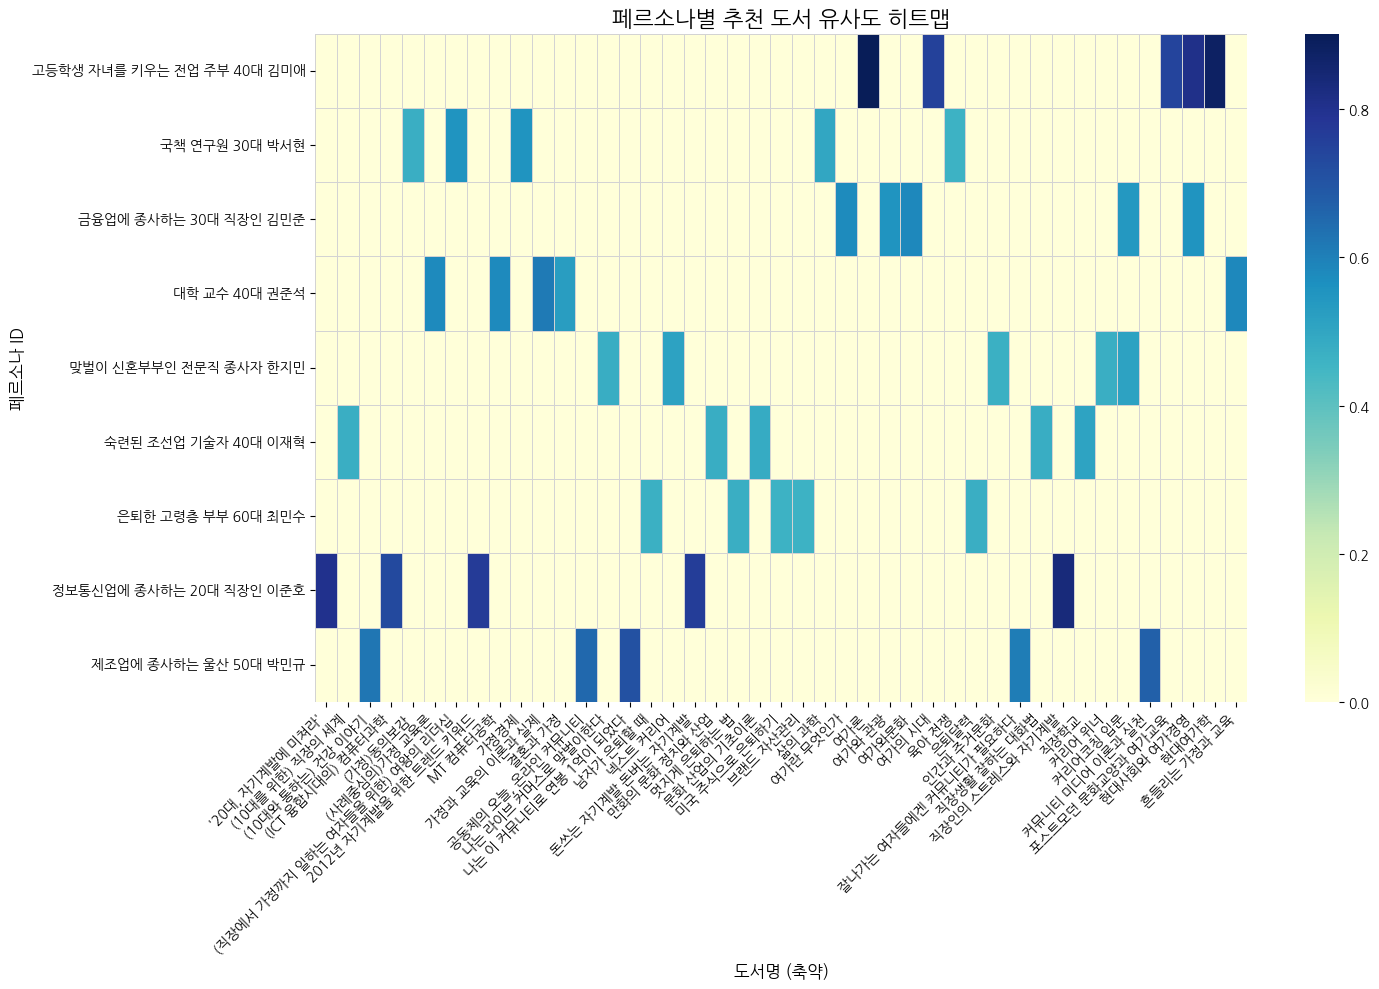

In [16]:
## 페르소나 ID & 추천 도서 유사도 히트맵 시각화

# 도서명 축약 함수 정의 (표제관련정보 및 대등표제 표기 X)
def truncate_book_title(title):
    if not isinstance(title, str):
        return title

    # ':' 또는 '='을 기준으로 분할
    parts = re.split(r'[:|=]', title, 1)

    return parts[0].strip()  # 앞뒤 공백 제거

# 시각화를 위한 데이터 준비
heatmap_data = combined_recommendations_df[['페르소나_ID', '도서명', '유사도']].copy()

# 도서명 축약 적용
heatmap_data['도서명_축약'] = heatmap_data['도서명'].apply(truncate_book_title)

# 피벗 테이블 생성
pivot_table = heatmap_data.pivot_table(
    index='페르소나_ID',
    columns='도서명_축약',
    values='유사도',
    fill_value=0  # 유사도가 없는 경우 0으로 채움
)

if not pivot_table.empty:
    plt.figure(figsize=(15, 10))

    # seaborn 히트맵 생성
    sns.heatmap(
        pivot_table,
        annot=False,
        cmap='YlGnBu',
        linewidths=.5,
        linecolor='lightgray'
    )

    plt.title('페르소나별 추천 도서 유사도 히트맵', fontsize=16)

    # x, y축 레이블 설정
    plt.xlabel('도서명 (축약)', fontsize=12)
    plt.ylabel('페르소나 ID', fontsize=12)

    # y축 레이블 회전 방지
    plt.yticks(rotation=0)

    # x축 레이블 회전 적용
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()

    # 시각화 저장
    plt.savefig("persona_book_similarity_heatmap.png", dpi=300, bbox_inches="tight")

    plt.show()

In [19]:
## 저장된 JSON 파일 정상 저장 확인

# 저장된 JSON 파일 불러오기
# df = pd.read_json("final_recommendations.json", orient="records", encoding="utf-8")

# 데이터프레임 확인
# print(df)

# 열 이름 확인
# print("\n컬럼 목록:", df.columns.tolist())

# 결측치 여부 체크
# print("\n결측치 개수:")
# print(df.isnull().sum())

In [20]:
## 책소개 텍스트 데이터 로드

# 책소개 데이터가 저장된  경로 및 파일명
# drive_folder_path = "/content/drive/MyDrive/Colab Notebooks/데이터"
# json_file_name = "book_introductions.json"
# full_file_path = os.path.join(drive_folder_path, json_file_name)

# JSON 파일에서 책소개 데이터 로드
# book_intro_data = {}

#with open(full_file_path, 'r', encoding='utf-8') as f:
    # book_intro_data = json.load(f)
# print(f"책 소개 데이터가 '{full_file_path}'에서 성공적으로 로드되었습니다.")
# print(f"로드된 책 소개 데이터 개수: {len(book_intro_data)}")

# 로드된 데이터 출력
# for i, (title, intro) in enumerate(book_intro_data.items()):
    # if i >= 10:  # 처음 10개 항목만 출력
        # break
    # print(f"제목: {title}")
    # print(f"소개: {intro[:200]}...")  # 소개글은 일부만 출력
    # print("-" * 20)